## 최적의 음식점 입점 위치 분석


#### 목표
서울특별시에서 치킨집을 창업할 시, 어느 프랜차이즈를 선정하여 어느 위치에 입점할지 분석


#### 데이터

1. 서울시 요식업 공공데이터
2. 서울시 구, 동별 인구 데이터
3. 치킨집 프랜차이즈별 창업비용, 폐업률, 특징 등



#### 분석 요약

1. 프랜차이즈 선정

- 3년 폐업률 평균이 낮고 틈새시장을 노릴 수 있는 치킨 브랜드 선정
- 60계 치킨은 3년 폐업률 5%, 건강브랜드로 틈새시장 공략 가능
- 지코바치킨 (오븐치킨)은 3년 폐업률 7%, 치킨 수요는 많으나 오븐치킨점이 없는 지역 공략



2. 위치 선정
   
- 60계 치킨은 10대 상주인구가 많고 건강치킨 브랜드가 입점하지 않은 곳 선정
- 송파구 삼전동은 치킨집 수요가 많고, 지역 평균 임대료 또한 안정화된 상태. 위의 조건을 만족시킨 지역 중 유일하게 60계 치킨이 입점하지 않은 지역. 
- 지코바치킨은 치킨수요가 많고 음식점 폐업률이 적으나 오븐치킨점이 입점하지 않은 곳
종로구 혜화동의 대학가 거리는 3개의 대학이 1km 반경 안에 있으며 위의 조건을 만족함 



3. 최종 선택

- 개별 프랜차이즈와 가맹점 문의를 통해 주요 경쟁 브랜드, 타겟 고객층 데이터 확보 
- 창업자의 자금력, 음식점 운영 경험 등을 종합적으로 고려하여 브랜드 및 매장형태 선택


In [1]:
!apt-get update -qq
!apt-get install -qq -y fonts-nanum

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 127400 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import matplotlib.font_manager as fm
import numpy as np
import warnings
from datetime import timedelta
import scipy.stats as stats
import re

In [3]:

file_path = '/kaggle/input/seoul-restaurant-info/.csv'
with open(file_path , "rb") as f:
    data = f.read(10000)
    result = chardet.detect(data)
    
print(result)

with open(file_path, "r", encoding="EUC-KR", errors="replace") as f:
    df = pd.read_csv(f)

df = df.iloc[:, :14]
df.info()

{'encoding': 'EUC-KR', 'confidence': 0.99, 'language': 'Korean'}


<ipython-input-3-cadc2bc6577f>:9: DtypeWarning: Columns (0,5,16,18,26,27,29,30,31,32,33,36,41,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515766 entries, 0 to 515765
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   인허가일자     515766 non-null  object 
 1   영업상태코드    515766 non-null  int64  
 2   영업상태명     515766 non-null  object 
 3   상세영업상태코드  515766 non-null  int64  
 4   상세영업상태명   515766 non-null  object 
 5   폐업일자      392248 non-null  object 
 6   지번주소      515538 non-null  object 
 7   도로명주소     265957 non-null  object 
 8   도로명우편번호   261776 non-null  float64
 9   사업장명      515765 non-null  object 
 10  최종수정일자    515766 non-null  object 
 11  업태구분명     515748 non-null  object 
 12  좌표정보(X)   490347 non-null  float64
 13  좌표정보(Y)   490347 non-null  float64
dtypes: float64(3), int64(2), object(9)
memory usage: 55.1+ MB


In [4]:
org_values = df['인허가일자'].copy()
df['인허가일자'] = pd.to_datetime(df['인허가일자'], errors = 'coerce', format = "%Y-%m-%d")
mask = df['인허가일자'].isna()
df.loc[mask, "인허가일자"] = pd.to_datetime(org_values[mask], errors = 'coerce', format = '%Y%m%d')
print(df['인허가일자'].isna().sum())


0


In [5]:
df.head(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,인허가일자,영업상태코드,영업상태명,상세영업상태코드,상세영업상태명,폐업일자,지번주소,도로명주소,도로명우편번호,사업장명,최종수정일자,업태구분명,좌표정보(X),좌표정보(Y)
0,2023-11-03,1,영업/정상,1,영업,NaN,서울특별시 중구 을지로6가 18-137,"서울특별시 중구 장충단로 249-10, 2층 (을지로6가)",4564.0,매취랑 동대문점,2023-11-03 17:09,한식,200614.4978,451667.7933
1,2024-08-02,1,영업/정상,1,영업,NaN,서울특별시 노원구 공릉동 334-3,서울특별시 노원구 공릉로 127 (공릉동),1837.0,BLUE BOX(블루박스),2024-08-02 11:28,기타,206888.2788,457681.1294
2,2023-05-12,1,영업/정상,1,영업,NaN,서울특별시 송파구 가락동 84-6,"서울특별시 송파구 송이로20길 12-1, 1층 101호 (가락동)",5712.0,치카바,2023-05-12 14:40,일식,210536.3795,443748.6844
3,2023-03-31,1,영업/정상,1,영업,NaN,서울특별시 송파구 방이동 57 One57빌당,"서울특별시 송파구 올림픽로34길 27-23, One57빌딩 2층 201호 (방이동)",5547.0,오고보,2023-03-31 9:55,경양식,209835.4199,445884.5368
4,2023-03-31,1,영업/정상,1,영업,NaN,서울특별시 송파구 가락동 46-11 문종빌딩,"서울특별시 송파구 오금로36길 64, 문종빌딩 1층 (가락동)",5706.0,또봉이통닭 가락본동점,2023-03-31 11:17,호프/통닭,210694.9140,444077.2546
5,2023-03-31,1,영업/정상,1,영업,NaN,서울특별시 송파구 문정동 644 문정현대지식산업센터1-1,"서울특별시 송파구 법원로11길 11, 문정현대지식산업센터1-1 B동 1층 152호 ...",5836.0,양이야기,2023-03-31 15:00,탕류(보신용),NaN,NaN
6,2023-03-31,1,영업/정상,1,영업,NaN,서울특별시 강동구 성내동 537-3,"서울특별시 강동구 성내로5길 31, 1층 101호 (성내동)",5392.0,대치동그집1981,2023-03-31 11:02,한식,210879.2516,447675.7397
7,2023-03-31,1,영업/정상,1,영업,NaN,서울특별시 강동구 천호동 46-28,"서울특별시 강동구 천중로43길 55, 1층 102호 (천호동)",5315.0,왔따쪽갈비,2023-03-31 16:00,한식,212416.3343,449042.6433
8,2023-03-31,1,영업/정상,1,영업,NaN,서울특별시 종로구 필운동 146-1 아이에스빌딩 1층,"서울특별시 종로구 필운대로 6-1, 아이에스빌딩 1층 (필운동)",3041.0,서촌 곳간,2023-03-31 11:17,한식,197228.1830,452706.9723
9,2024-09-05,1,영업/정상,1,영업,NaN,서울특별시 중랑구 면목동 198-27,"서울특별시 중랑구 중랑천로 67, 1층 (면목동)",2118.0,컴플리트커피,2024-09-23 11:02,기타,206368.0678,454321.0624


### EDA - 기본 정보 탐색

In [6]:
print(df['업태구분명'].unique())

['한식' '기타' '일식' '경양식' '호프/통닭' '탕류(보신용)' '중국식' '외국음식전문점(인도,태국등)' '식육(숯불구이)'
 '분식' '김밥(도시락)' '정종/대포집/소주방' '라이브카페' '횟집' '까페' '통닭(치킨)' '출장조리' '패밀리레스트랑'
 '뷔페식' '냉면집' '감성주점' '키즈카페' '패스트푸드' '전통찻집' '이동조리' '복어취급' nan '룸살롱' '커피숍'
 '다방' '간이주점' '기타 휴게음식점' '?ㅑ?대포집/소주방' '식품소분업' '일반조리판매' '식품등 수입판매업' '제과점영업']


In [7]:
print(df['업태구분명'].isna().sum())
print(df['업태구분명'].value_counts())

18
업태구분명
한식                 215400
분식                  80330
경양식                 50861
기타                  46320
호프/통닭               36926
일식                  20465
중국식                 16526
정종/대포집/소주방          12942
통닭(치킨)               9456
까페                   7835
패스트푸드                3890
외국음식전문점(인도,태국등)      3149
뷔페식                  2898
식육(숯불구이)             1949
김밥(도시락)              1686
횟집                   1586
전통찻집                  823
감성주점                  540
탕류(보신용)               432
출장조리                  406
패밀리레스트랑               352
라이브카페                 350
냉면집                   284
복어취급                  119
키즈카페                  106
이동조리                  101
커피숍                     4
기타 휴게음식점                3
일반조리판매                  2
룸살롱                     1
다방                      1
간이주점                    1
?ㅑ?대포집/소주방              1
식품소분업                   1
식품등 수입판매업               1
제과점영업                   1
Name: count, dtype: int64


<span style = "font-size:20px;">
    
1. 분석의 편의를 위해 매장수가 10 미만인 업체들은 제거하도록 한다. 
2. 결측값은 18개 정도로 전체 57만개에 비하면 매우 적은 수이므로 결측값도 단순제거한다.
3. 음식점에 관한 분석이므로 카페, 찻집, 출장조리는 제외하도록 한다

In [8]:
cleaned_df = df.copy()
cleaned_df.dropna(subset = '업태구분명',inplace= True)
sort_size =cleaned_df.groupby('업태구분명').size()
filter_index = sort_size[sort_size < 20 ].index
cleaned_df= cleaned_df[~cleaned_df['업태구분명'].isin(filter_index)  ]
cleaned_df = cleaned_df[~cleaned_df['업태구분명'].isin(['까페', '전통찻집', '키즈카페', '라이브카페', '출장조리'])]

In [9]:
print(cleaned_df['업태구분명'].value_counts())

업태구분명
한식                 215400
분식                  80330
경양식                 50861
기타                  46320
호프/통닭               36926
일식                  20465
중국식                 16526
정종/대포집/소주방          12942
통닭(치킨)               9456
패스트푸드                3890
외국음식전문점(인도,태국등)      3149
뷔페식                  2898
식육(숯불구이)             1949
김밥(도시락)              1686
횟집                   1586
감성주점                  540
탕류(보신용)               432
패밀리레스트랑               352
냉면집                   284
복어취급                  119
이동조리                  101
Name: count, dtype: int64


In [10]:
fericana_df = cleaned_df[cleaned_df['사업장명'].str.contains('페리카나', na= False) ]
print(fericana_df['업태구분명'].unique())
display(fericana_df)

['호프/통닭' '분식' '한식' '통닭(치킨)' '정종/대포집/소주방' '경양식' '일식' '기타' '뷔페식']


,인허가일자,영업상태코드,영업상태명,상세영업상태코드,상세영업상태명,폐업일자,지번주소,도로명주소,도로명우편번호,사업장명,최종수정일자,업태구분명,좌표정보(X),좌표정보(Y)
367,2017-08-14,3,폐업,2,폐업,2023-02-28,서울특별시 양천구 신정동 336 청구아파트상가 지상1층 103호,"서울특별시 양천구 신목로2길 11, 지상1층 103호 (신정동, 청구아파트상가)",8015.0,페리카나,2023-02-28 11:58,호프/통닭,188934.3191,446320.4779
3812,2023-03-10,1,영업/정상,1,영업,NaN,서울특별시 양천구 신정동 336 청구아파트,"서울특별시 양천구 신목로2길 11, 상가동 1층 103호 (신정동, 청구아파트)",8015.0,페리카나 신정2점,2024-03-20 13:20,호프/통닭,188934.3191,446320.4779
5385,2023-11-08,1,영업/정상,1,영업,NaN,서울특별시 관악구 봉천동 1642-7,"서울특별시 관악구 인헌3가길 2, 1층 (봉천동)",8795.0,페리카나 낙성대1점,2023-11-08 13:11,호프/통닭,197043.0537,441341.0481
5501,1993-08-04,3,폐업,2,폐업,2023-07-11,서울특별시 마포구 중동 64-25 현대상가,"서울특별시 마포구 월드컵북로 230, 현대상가 2층 5호 (중동)",3941.0,성산동페리카나,2023-07-11 9:03,분식,191435.8770,451990.7078
6523,1993-11-24,3,폐업,2,폐업,2023-03-20,서울특별시 용산구 용산동2가 1-46 (지상1층),"서울특별시 용산구 소월로20길 28-1 (용산동2가,(지상1층))",4337.0,페리카나 해방촌지점,2023-03-20 10:28,분식,198622.1782,449221.6800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502446,2003-08-06,3,폐업,2,폐업,2024-04-24,서울특별시 강서구 방화동 487-8 (지상 1층),"서울특별시 강서구 양천로11길 8, 1층 (방화동, 1동)",7516.0,페리카나치킨,2024-04-24 13:14,통닭(치킨),183149.9959,452391.7762
503155,2011-01-12,1,영업/정상,1,영업,NaN,서울특별시 영등포구 여의도동 50 여의도시범아파트,"서울특별시 영등포구 63로 45, 2,3,4동 1층 117호 (여의도동, 여의도시범...",7344.0,여의도페리카나치킨,2022-06-02 11:13,한식,194370.3272,446497.5239
510119,2008-07-08,1,영업/정상,1,영업,NaN,서울특별시 강서구 가양동 1480-1 이스타빌2차 101-1,"서울특별시 강서구 양천로57길 10-11, 이스타빌2차 1층 101-1호 (가양동)",7526.0,페리카나치킨,2022-09-13 13:36,한식,186915.4800,451230.0882
510333,2004-06-16,3,폐업,2,폐업,20220928,서울특별시 강남구 삼성동 26,"서울특별시 강남구 삼성로119길 41, 1층 (삼성동)",6094.0,페리카나치킨,2022-09-28 15:14,통닭(치킨),204191.6525,445885.7257


<span style = 'font-size:20px;'>
여기에 문제가 있다. 페리카나, 교촌 등의 경우 명백하게 치킨업종이지만, 한식이나 분식 등 여러 업종으로 구분되어있다. <br>
이 문제는 쉽게 해결이 불가능하므로 우선 각 지역, 구별 음식점 평균 매장 갯수부터 알아보자

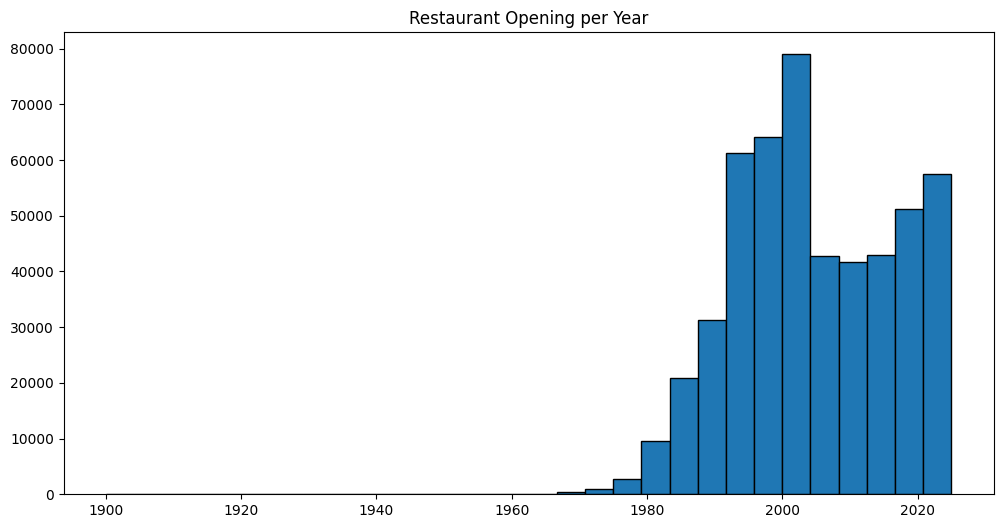

In [11]:
cleaned_df['인허가 연도'] = cleaned_df['인허가일자'].dt.year
plt.figure(figsize = (12, 6))
plt.hist(cleaned_df['인허가 연도'], bins = 30, edgecolor = 'black')
plt.title('Restaurant Opening per Year')
plt.show()

<span style = 'font-size:20px'>
우리의 목표는 2025년 1월1일을 기준으로 음식점을 입점할만한 위치를 찾는 것.
검증을 위해서 2010~2024년의 데이터를 사용할 예정이다.
따라서 2010년 이전에 폐업한 데이터는 삭제하도록 하자.

In [12]:
closed_df = cleaned_df[cleaned_df['상세영업상태코드'] == 2].copy()
print(closed_df['폐업일자'].isna().sum())
org_value = closed_df['폐업일자'].copy()
closed_df['폐업일자'] = pd.to_datetime(closed_df['폐업일자'], format = '%Y-%m-%d', errors = 'coerce' )
mask = closed_df['폐업일자'].isna()
converted_dates  = org_value[mask].dropna().astype(float).astype(int).astype(str)
closed_df.loc[mask, '폐업일자'] = pd.to_datetime(converted_dates, errors ='coerce', format = '%Y%m%d')
print(closed_df['폐업일자'].isna().sum())
na_index= closed_df[closed_df['폐업일자'].isna()].index
print(len(na_index))
closed_df.dropna(subset= '폐업일자', inplace= True)
print(closed_df['폐업일자'].isna().sum())
convert_index = closed_df['폐업일자'].index
closed_df['폐업 년도'] = closed_df['폐업일자'].dt.year
closed_before_2010 = closed_df[closed_df['폐업 년도'] < 2010].index

0
1
1
0


In [13]:
cleaned_df2 = cleaned_df.copy()
cleaned_df2.drop(index = na_index, inplace = True)
cleaned_df2.loc[convert_index, '폐업일자'] = closed_df.loc[convert_index, '폐업일자']
cleaned_df2.drop(index = closed_before_2010, inplace = True)

2010년 이전에 폐업한 매장들은 제거하였다. 이제 각 구별로 년도별 매장 갯수 추이를 보자. 

In [14]:
cleaned_df3 = cleaned_df2.copy()
cleaned_df3['구'] = cleaned_df3['지번주소'].str.extract(r'서울특별시 (\S+구)')
na_index = cleaned_df3[cleaned_df3['구'].isna()].index
cleaned_df3.loc[na_index, '구'] = (cleaned_df3.loc[na_index, '도로명주소']
                                  .fillna("")
                                  .str.extract(r'서울특별시 (\S+구)')[0])
regions = ['경기도', '제주특별자치도', '부산광역시']
filter_index = cleaned_df3[cleaned_df3['도로명주소'].str
                .contains('|'.join(regions), na= False)].index
filter_index = cleaned_df3[cleaned_df3['지번주소'].str
                .contains('|'.join(regions), na= False)].index
cleaned_df3.drop(index = filter_index, inplace =True)
cleaned_df3['구'].isna().sum()
cleaned_df3['폐업일자'] = pd.to_datetime(cleaned_df3['폐업일자'], errors = 'coerce')

In [15]:
gu_rest_num = pd.DataFrame()

def extract_year_df(df, year):
    df_year = df[ (df['인허가일자'] < datetime(year,1,1) ) &
                  (df['폐업일자'].fillna(datetime(2030,1,1)) > datetime(year,1,1) ) ]
    df_year = df_year.copy()
    gu_year = df_year.groupby('구').size().sort_values(ascending = False).reset_index(name = '매장 수')
    gu_year['해당 년도'] = year
    return gu_year


for i in range(2015, 2026):
    gu_year_data = extract_year_df(cleaned_df3, i)
    gu_rest_num = pd.concat([gu_rest_num, gu_year_data], axis=0)


In [16]:
commercial_district = ['강남구', '종로구', '중구', '영등포구', '서초구']
mixed_district = ['마포구', '용산구', '성동구', '광진구', '송파구', '노원구', '은평구', '강동구', '관악구', '동작구', '서대문구']
residence_district = ['강서구', '구로구', '금천구', '양천구', '동대문구', '성북구', '강북구', '중랑구', '도봉구'] 

gu_rest_num_1 = gu_rest_num[gu_rest_num['구'].isin(commercial_district)]
gu_rest_num_2 = gu_rest_num[gu_rest_num['구'].isin(mixed_district)]
gu_rest_num_3 = gu_rest_num[gu_rest_num['구'].isin(residence_district)]

1. 도심상권인 구들은 주로
   a. 유동인구가 많고
   b. 배달보단 매장방문이 많으며
   c. 경쟁반경 500m ~ 1km

2. 복합상권인 구들은 주로
    a. 배달과 매장방문 모두가 중요하며
    b. 경쟁반경 700m ~ 2km

3. 주거상권인 구들은 주로
   a. 상주인구가 많고
   b. 배달위주이고
   c. 경쟁반경 1.5km ~ 3km


<span style = 'font-size:18px;'>

그 다음으로, 서울시 전체의 3년 폐업률 변화량과 구 별 변화량을 알아보자 

In [20]:
cleaned_df3['1년 폐업 여부'] = (cleaned_df3['폐업일자'].fillna(datetime(2030,1,1)) 
                  <= cleaned_df3['인허가일자'] + timedelta(days = 1 * 365 + 90)).astype(int)

cleaned_df3['3년 폐업 여부'] = (cleaned_df3['폐업일자'].fillna(datetime(2030,1,1)) 
                  <= cleaned_df3['인허가일자'] + timedelta(days = 3 * 365 + 90 )).astype(int)

cleaned_df3['5년 폐업 여부'] = (cleaned_df3['폐업일자'].fillna(datetime(2030,1,1)) 
                  <= cleaned_df3['인허가일자'] + timedelta(days = 5 * 365 + 90)).astype(int)
for_1year = cleaned_df3[ (cleaned_df3['인허가 연도'] < 2024) & (cleaned_df3['인허가 연도'] >= 2018)]
for_3year = cleaned_df3[ (cleaned_df3['인허가 연도'] < 2022) & (cleaned_df3['인허가 연도'] >= 2018)]
for_5year = cleaned_df3[ (cleaned_df3['인허가 연도'] < 2020) & (cleaned_df3['인허가 연도'] >= 2018)]

within_1year = for_1year['1년 폐업 여부'].mean().round(2) 
within_3year = for_3year['3년 폐업 여부'].mean().round(2)
within_5year = for_5year['5년 폐업 여부'].mean().round(2)
print(f"서울시의 1년 내 폐업률: {(within_1year * 100).astype(int)}%\n"
      f"서울시의 3년 내 폐업률: {(within_3year * 100).astype(int)}%\n"
      f"서울시의 5년 내 폐업률: {(within_5year * 100).astype(int)}%")

서울시의 1년 내 폐업률: 17%
서울시의 3년 내 폐업률: 38%
서울시의 5년 내 폐업률: 51%


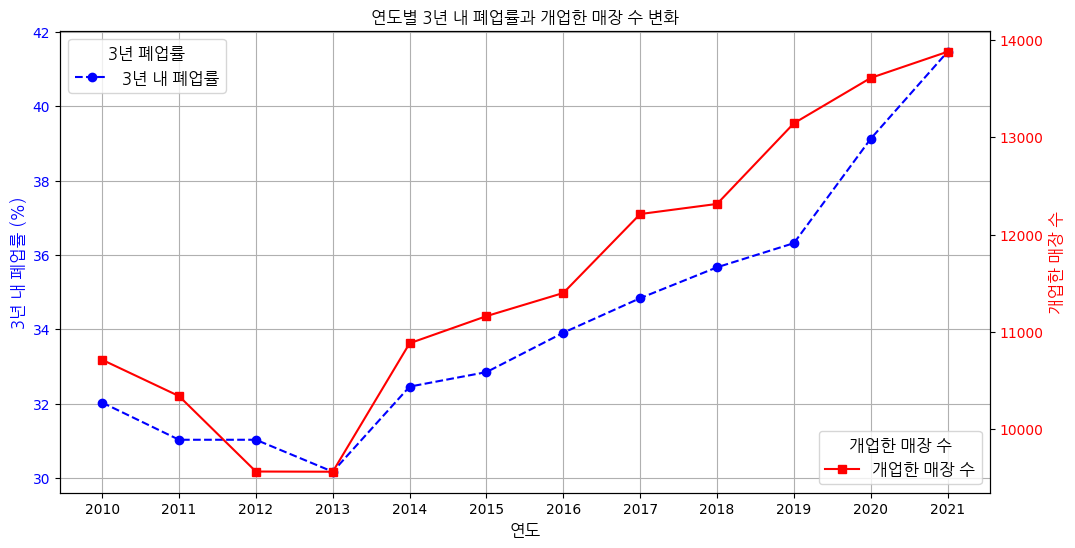

In [21]:
yearly_counts = cleaned_df3.groupby('인허가 연도')['3년 폐업 여부'].agg(['count', 'mean']).reset_index()
yearly_counts =yearly_counts[ ( yearly_counts['인허가 연도'] >= 2010 ) & ( yearly_counts['인허가 연도'] <= 2021 )]
yearly_counts['mean'] = (yearly_counts['mean'] * 100).round(2)

fig, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(yearly_counts['인허가 연도'], yearly_counts['mean'], marker = 'o', 
         linestyle = '--', color = 'b', label = '3년 내 폐업률')
ax1.set_xlabel('연도', fontproperties = fontprop)
ax1.set_ylabel('3년 내 폐업률 (%)', fontproperties=fontprop, color='b')
ax1.tick_params(axis = 'y', labelcolor = 'b')
ax1.grid(True)


ax2 = ax1.twinx()
ax2.plot(yearly_counts['인허가 연도'], yearly_counts['count'], marker='s', 
         linestyle='-', color='r', label='개업한 매장 수')
ax2.set_ylabel('개업한 매장 수', fontproperties=fontprop, color='r')
ax2.tick_params(axis='y', labelcolor='r')


ax1.legend(title = '3년 폐업률', loc = 'upper left', title_fontproperties = fontprop, prop = fontprop)
ax2.legend(title = '개업한 매장 수',loc='lower right', title_fontproperties = fontprop, prop = fontprop)


plt.title('연도별 3년 내 폐업률과 개업한 매장 수 변화', fontproperties=fontprop)

plt.xticks(range(2010, 2022))

plt.show()

<span style = 'font-size:18px;'>

1. 2020년, 2021년은 코로나로 인한 급격한 페업률 증가가 눈에 띈다.
2. 2014~2019년 사이 역시 서서히 증가하고 있던 추세였다
3. 개업하는 신규 매장 수는 코로나 시기에도 계속해서 늘고있던 추세였다.
4. 지난 10년간 서울시의 인구는 지속적으로 줄어들었음을 고려할 때, 최근 10년간 매 해 개업하는 매장 수가 꾸준히 늘어났다는 것은 흥미로운 부분이다
5. 그래프를 보면 각 년도에 개업한 매장 수와, 해당 매장들의 3년내 폐업률은 비례함을 시각적으로 확인할 수 있다. 정확한 상관계수를 알아보자.

In [22]:
corr_coef, p_value = stats.pearsonr(yearly_counts['count'], yearly_counts['mean'])
print(corr_coef, p_value)
print("피어슨 상관계수는 약 0.95 정도로 매우 강한 양의 상관관계를 지닌다")

0.96249665309019 5.486044676417036e-07
피어슨 상관계수는 약 0.95 정도로 매우 강한 양의 상관관계를 지닌다


In [23]:
after_2010 = cleaned_df3.copy()
after_2010 = after_2010[(after_2010['인허가 연도'] > 2009) & (after_2010['인허가 연도'] < 2022)]
after_2010_df = after_2010.groupby(['인허가 연도', '구'])['3년 폐업 여부'].agg(['count', 'mean']).reset_index()
after_2010_df['mean'] = ( after_2010_df['mean'] * 100 ).round(2)
print(len(after_2010_df[after_2010_df['count'] < 200]) )

after_2010_1 = after_2010_df[after_2010_df['구'].isin(commercial_district)]
after_2010_2 = after_2010_df[after_2010_df['구'].isin(mixed_district)]
after_2010_3 = after_2010_df[after_2010_df['구'].isin(residence_district)]


0


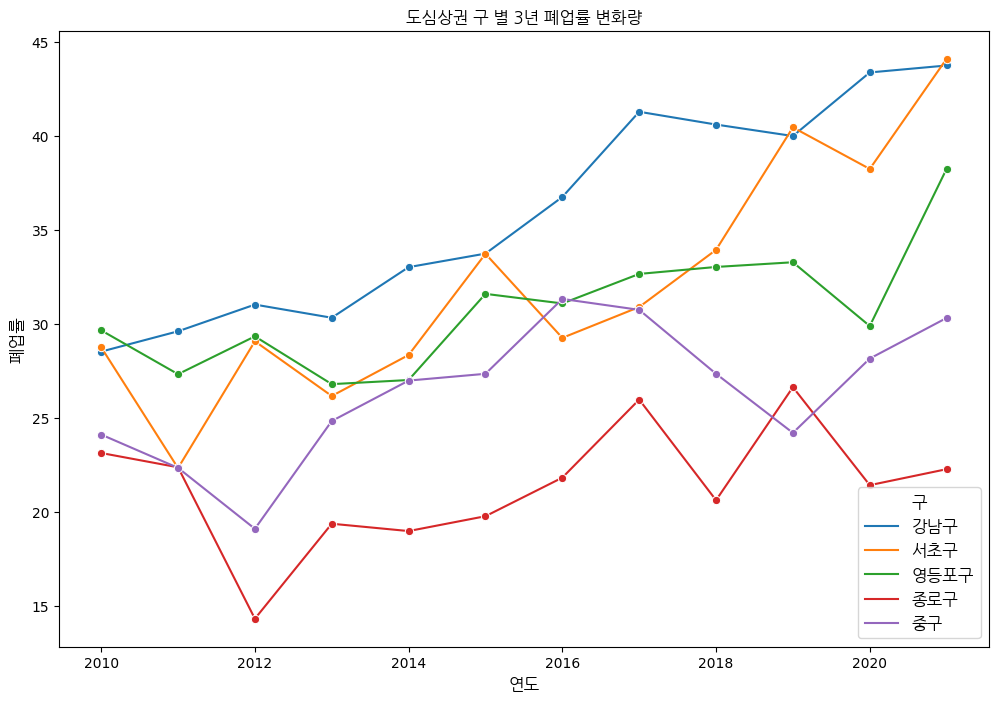

In [24]:
plt.figure(figsize = (12, 8))
sns.lineplot(x = '인허가 연도', y = 'mean', data = after_2010_1, 
            hue= '구', marker = 'o')

plt.xlabel('연도', fontproperties = fontprop)
plt.ylabel('폐업률', fontproperties = fontprop)
plt.title('도심상권 구 별 3년 폐업률 변화량', fontproperties = fontprop)
plt.legend(title = '구', title_fontproperties =fontprop, prop = fontprop, loc = 'lower right')
plt.show()

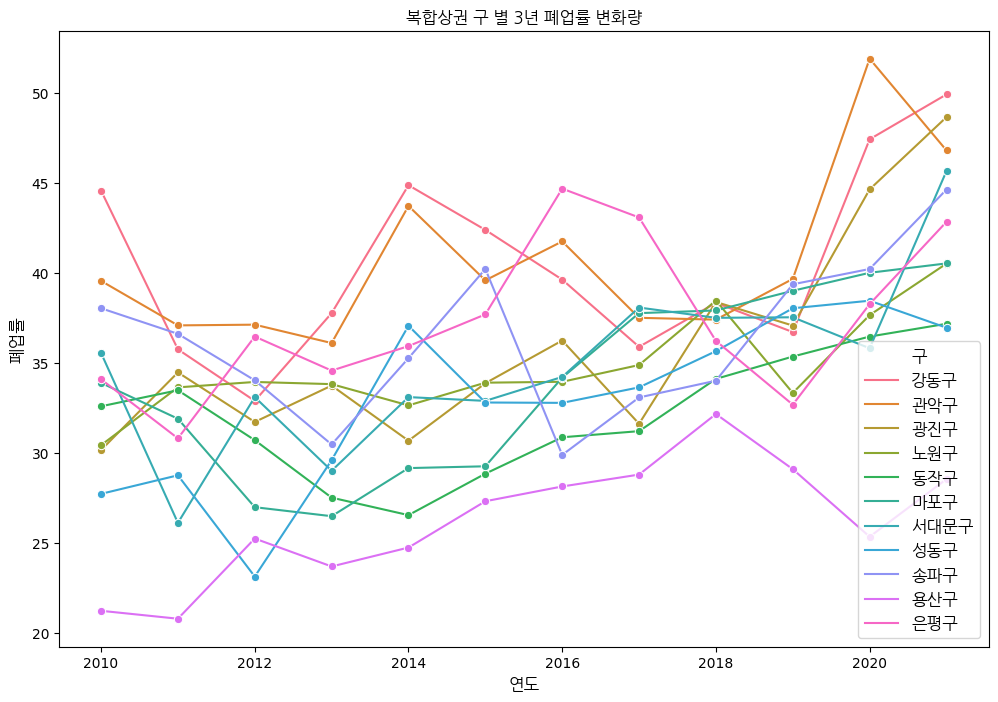

In [25]:
plt.figure(figsize = (12, 8))
sns.lineplot(x = '인허가 연도', y = 'mean', data = after_2010_2, 
            hue= '구', marker = 'o')

plt.xlabel('연도', fontproperties = fontprop)
plt.ylabel('폐업률', fontproperties = fontprop)
plt.title('복합상권 구 별 3년 폐업률 변화량', fontproperties = fontprop)
plt.legend(title = '구', title_fontproperties =fontprop, prop = fontprop, loc = 'lower right')
plt.show()

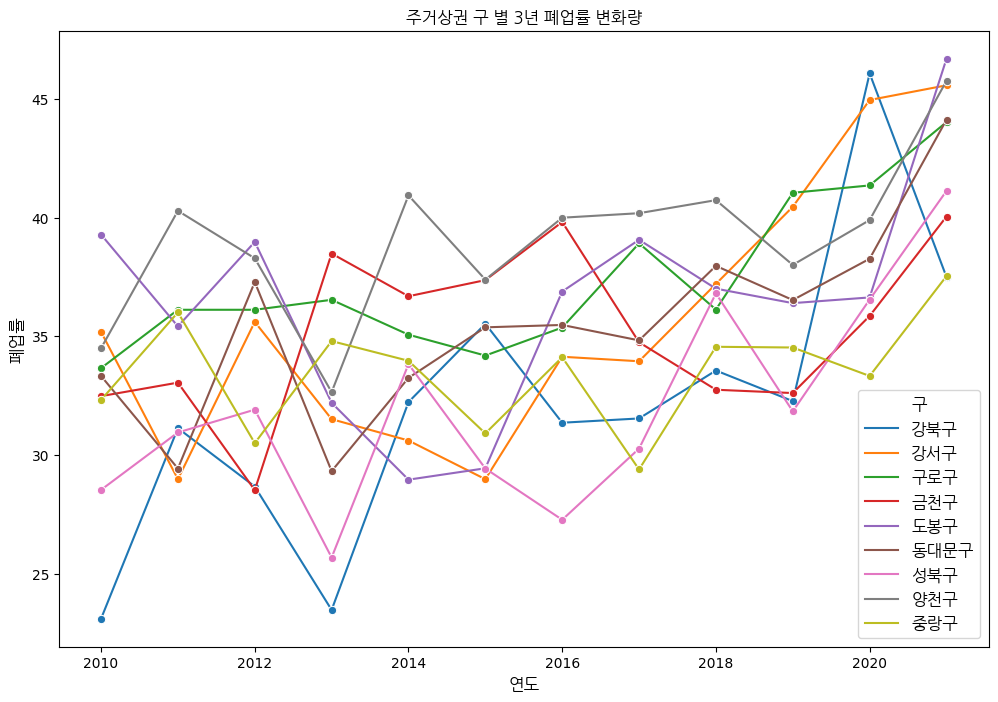

In [26]:
plt.figure(figsize = (12, 8))
sns.lineplot(x = '인허가 연도', y = 'mean', data = after_2010_3, 
            hue= '구', marker = 'o')

plt.xlabel('연도', fontproperties = fontprop)
plt.ylabel('폐업률', fontproperties = fontprop)
plt.title('주거상권 구 별 3년 폐업률 변화량', fontproperties = fontprop)
plt.legend(title = '구', title_fontproperties =fontprop, prop = fontprop, loc = 'lower right')
plt.show()

<span style = 'font-size:18px;'>

1. 용산구, 종로구 정도만 20%를 유지하고 있고, 나머지는 대부분 상승세를 보여준다.
2. 강서구, 강남구, 강동구, 관악구 등은 40%을 넘기기도 한다.

그렇다면 해당 구들의 년도 별 개업 매장 수 변화량은 어떨까?

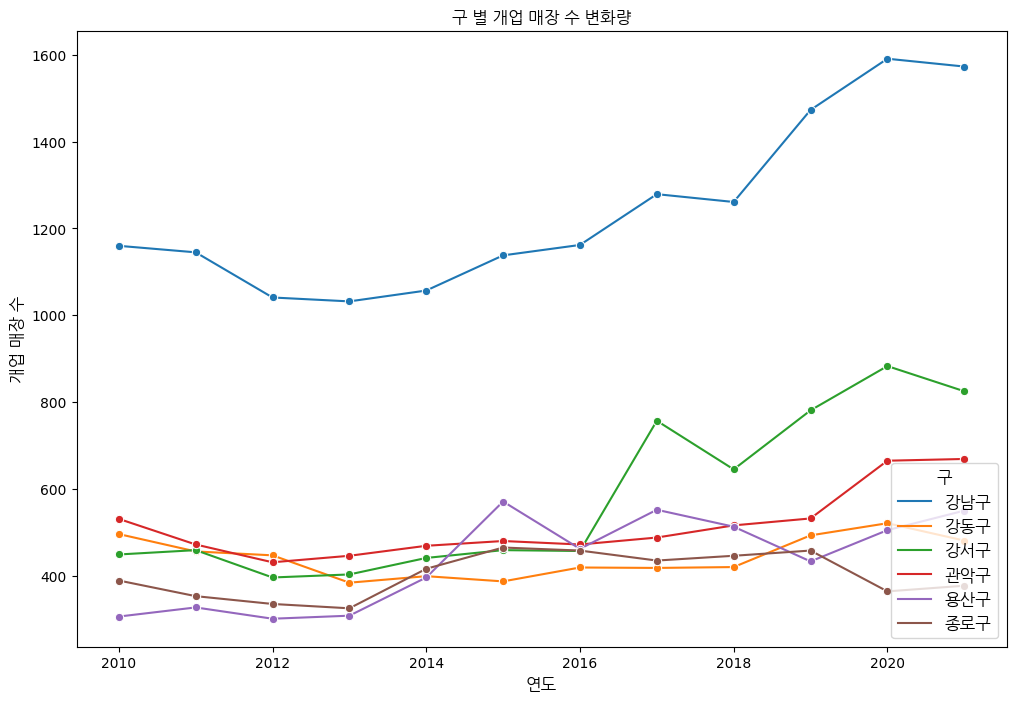

In [27]:
after_2010_count = after_2010_df[after_2010_df['구'].isin(['강남구', '강서구', '강동구', '관악구',
                                                         '용산구', '종로구'])]

plt.figure(figsize = (12, 8))
sns.lineplot(x = '인허가 연도', y = 'count', data = after_2010_count,
            hue= '구', marker = 'o')

plt.xlabel('연도', fontproperties = fontprop)
plt.ylabel('개업 매장 수', fontproperties = fontprop)
plt.title('구 별 개업 매장 수 변화량', fontproperties = fontprop)
plt.legend(title = '구', title_fontproperties =fontprop, prop = fontprop, loc = 'lower right')
plt.show()

<span style = 'font-size:18px;'>
    
1. 강남, 강서는 매장수의 급격한 상승세가 눈에 띈다.
2. 종로구, 용산구는 2015년을 기점으로 늘지 않는 편.
   
그렇다면 종로구, 용산구에 매점을 입점하는게 최적의 방법일까? 

-----

추가 EDA:

1. 업종별로 폐업률은 다를까?
2. 각 구마다 업종별로 매장 수를 차지하는 비율이 다를까? 만약 어떤 구에서
특정 업종 (가령 치킨집)의 비율이 평균에 비해 현저히 적다면, 해당 구에서 해당 업종을 창업하는 것이 좋은 전략일까?
   

<font size = "3">
전처리 후, 비율이 상위 10개인 것만 남기도록 하자 (분석의 편의성을 위해) <br>
현재 사업장명과 업태구분명이 맞지않는 것들이 많아서 (교촌치킨, 페리카나 등이 한식이나 분식으로 분류되는 등) 전처리 필요

In [28]:
cleaned_df4 = cleaned_df3.copy()

cleaned_df4.dropna(subset = '사업장명', inplace = True)
chicken_brands = [
    'BBQ', 'BHC', '교촌', '네네', '굽네', '처갓집양념', '노랑통닭', '60계',
    '페리', '호식이두마리', '멕시카나', '지코바', '또래오래',  '푸라닭', 
    '가마로강정', '맘스터치', '땅땅', '오븐마루', '푸라닭', '가마치',
    '깐부', '치킨', '후라이드', '또봉이', '자담', '티바두마리', '강정', '오븐', '가마꿉', '기영이', '훌랄라치킨', 
    '꾸브라꼬', '뭔닭인지알지', '굽고굽고', '오븐에꾸운닭', '구어조은닭','돈치킨','본스치킨', '핫썬치킨'

]

chicken_pattern = '|'.join(chicken_brands)
chick_idx = cleaned_df4[cleaned_df4['사업장명'].str.contains(
    chicken_pattern, na=False, regex=True, flags=re.IGNORECASE)].index
cleaned_df4.loc[chick_idx, '업태구분명'] = '치킨'


drop_list = ['카페', '까페', 'cafe', '커피', '펍', '스타벅스']
drop_pattern = '|'.join(drop_list)
drop_idx = cleaned_df4[cleaned_df4['사업장명'].str.contains(
    drop_pattern, na = False, regex = True, flags = re.IGNORECASE)].index
cleaned_df4.drop(index = drop_idx, inplace = True)


drop_idx2 = cleaned_df4[cleaned_df4['업태구분명'] == '감성주점'  ].index
cleaned_df4.drop(index= drop_idx2, inplace = True)


others_list = ['이동조리', '복어취급', '뷔페식', '냉면집', '패밀리레스트랑',
               '탕류(보신용)', '김밥(도시락)', '식육(숯불구이)', 
               '외국음식전문점(인도,태국등)', '횟집']

others_idx = cleaned_df4[cleaned_df4['업태구분명'].isin(others_list)].index


cleaned_df4.loc[others_idx, '업태구분명']  = '기타'

pizza_idx = cleaned_df4[cleaned_df4['사업장명'].str.contains('피자')].index
cleaned_df4.loc[pizza_idx, '업태구분명']  = '피자'


burger_idx = cleaned_df4[cleaned_df4['사업장명'].str.contains('버거')].index
cleaned_df4.loc[burger_idx, '업태구분명']  = '기타'


pub_idx = cleaned_df4[cleaned_df4['업태구분명'] == '호프/통닭'].index
cleaned_df4.loc[pub_idx, '업태구분명'] = '호프'

others_idx2 = cleaned_df4[cleaned_df4['업태구분명'] == '정종/대포집/소주방'].index
cleaned_df4.loc[others_idx2, '업태구분명'] = '기타'

others_idx3 = cleaned_df4[cleaned_df4['업태구분명'] == '패스트푸드'].index
cleaned_df4.loc[others_idx3, '업태구분명'] = '기타'

pub_list = ['호프', '포장마차', '포차', '맥주']
pub_pattern = '|'.join(pub_list)
bunsick_list = ['떡볶이', '스쿨푸드', '김밥']
bunsick_pattern = '|'.join(bunsick_list)
pub_idx = cleaned_df4[cleaned_df4['사업장명'].str.
                    contains(pub_pattern, na= False, regex = True, flags = re.IGNORECASE )].index
bunsick_idx = cleaned_df4[cleaned_df4['사업장명'].str.
                    contains(bunsick_pattern, na= False, regex = True, flags = re.IGNORECASE )].index
kor_idx = cleaned_df4[cleaned_df4['사업장명'].str.contains('찜닭')].index

cleaned_df4.loc[pub_idx, '업태구분명'] = '호프'
cleaned_df4.loc[bunsick_idx, '업태구분명'] = '분식'
cleaned_df4.loc[kor_idx, '업태구분명'] = '한식'

In [29]:
cleaned_df5 = cleaned_df4.copy()
cleaned_df5 = cleaned_df5[cleaned_df5['영업상태코드'] == 1]

cleaned_df5.dropna(subset = '사업장명', inplace = True)
round(cleaned_df5['업태구분명'].value_counts(normalize =True) * 100, 2 )

업태구분명
한식        42.73
기타        19.67
호프         7.89
분식         7.49
경양식        6.76
일식         5.68
중국식        4.07
치킨         3.82
피자         1.24
통닭(치킨)     0.66
Name: proportion, dtype: float64

<font size = "3">

    
첫번째 질문: 각 지구 / 구별로 업종 비율은 다를까?

In [30]:
commercial_district = ['강남구', '종로구', '중구', '영등포구', '서초구']
mixed_district = ['마포구', '용산구', '성동구', '광진구', '송파구', '노원구', '은평구', '강동구', '관악구', '서대문구', '동작구']
residence_district = ['강서구', '구로구', '금천구', '양천구', '동대문구', '성북구', '강북구', '중랑구', '도봉구'] 


commercial_df = cleaned_df5[cleaned_df5['구'].isin(commercial_district)]
mixed_df = cleaned_df5[cleaned_df5['구'].isin(mixed_district)]
residence_df = cleaned_df5[cleaned_df5['구'].isin(residence_district)]


commercial_ratio = round(commercial_df['업태구분명'].value_counts(normalize=True) * 100, 2)
mixed_ratio = round(mixed_df['업태구분명'].value_counts(normalize=True) * 100, 2)
residence_ratio = round(residence_df['업태구분명'].value_counts(normalize=True) * 100, 2)


district_ratio_df = pd.DataFrame({
    '상업지구': commercial_ratio,
    '혼합지구': mixed_ratio,
    '주거지구': residence_ratio
}).fillna(0) 

display(district_ratio_df)

,상업지구,혼합지구,주거지구
업태구분명,,,
경양식,10.94,6.08,3.15
기타,18.10,22.20,17.50
분식,7.85,7.34,7.33
일식,6.67,5.86,4.31
중국식,4.35,3.65,4.39
치킨,2.56,4.05,4.86
통닭(치킨),0.45,0.60,0.97
피자,0.85,1.39,1.43
한식,43.33,40.64,45.28


1. 피자, 치킨처럼 배달 위주의 업종은 상업지구에서 비율이 가장 낮다
2. 일식, 경양식의 경우 상업지구에서 주거지구로 갈 수록 비율이 낮아진다
3. 호프는 상업지구 -> 주거지구로 갈 수록 비율이 높아진다.

각 지역의 특성에 따라 비율이 다르다는 것은 확인했다. 그렇다면 구 별 차이는 어떨까?

In [31]:
gu_list = cleaned_df5['구'].unique()

gu_list1 = gu_list[:13]
gu_list2 = gu_list[13:]
gu_ratio_df1 = pd.DataFrame()
gu_ratio_df2 = pd.DataFrame()

for i in gu_list1:
    temp_df = cleaned_df5[cleaned_df5['구'] == i]
    temp_ratio = round(temp_df['업태구분명'].value_counts(normalize=True) * 100, 2)
    gu_ratio_df1 = pd.concat([gu_ratio_df1, temp_ratio.rename(i)], axis=1)


for i in gu_list2:
    temp_df = cleaned_df5[cleaned_df5['구'] == i]
    temp_ratio = round(temp_df['업태구분명'].value_counts(normalize=True) * 100, 2)
    gu_ratio_df2 = pd.concat([gu_ratio_df2, temp_ratio.rename(i)], axis=1)


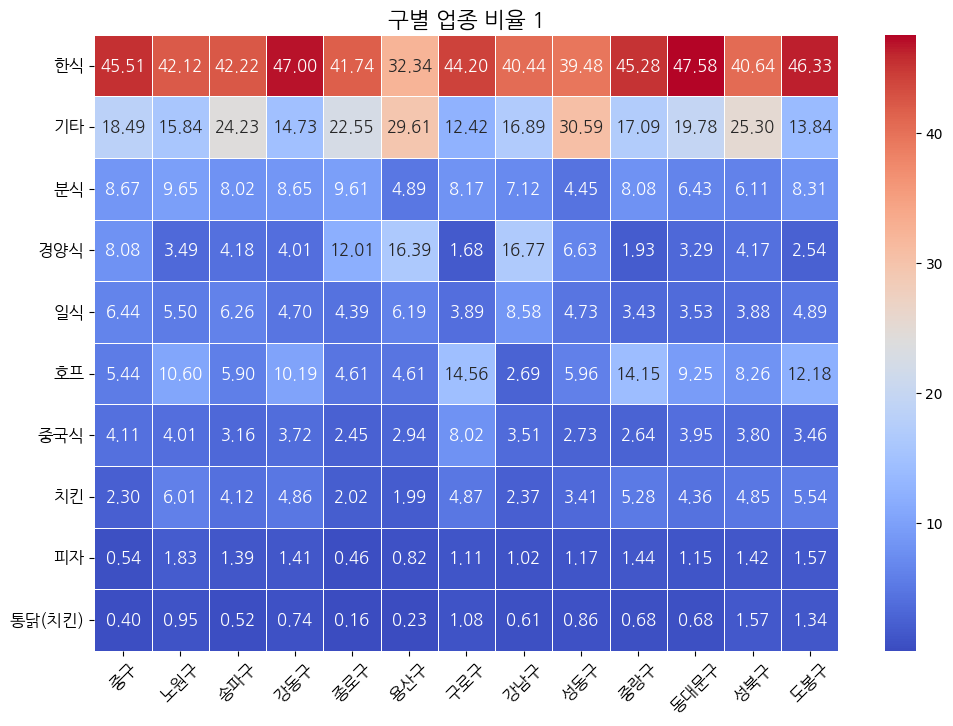

In [32]:
warnings.filterwarnings("ignore", message="Glyph .* missing from current font")

plt.figure(figsize=(12, 8))
ax = sns.heatmap(gu_ratio_df1, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# X축, Y축 한글 폰트 적용
plt.xticks(fontsize=14, rotation=45, fontproperties=fontprop)
plt.yticks(fontsize=14, rotation=0, fontproperties=fontprop)
plt.title("구별 업종 비율 1", fontproperties=fontprop, fontsize=16)

# Seaborn 내부 텍스트(annot)에도 한글 폰트 강제 적용
for text in ax.texts:
    text.set_fontproperties(fontprop)

plt.show()


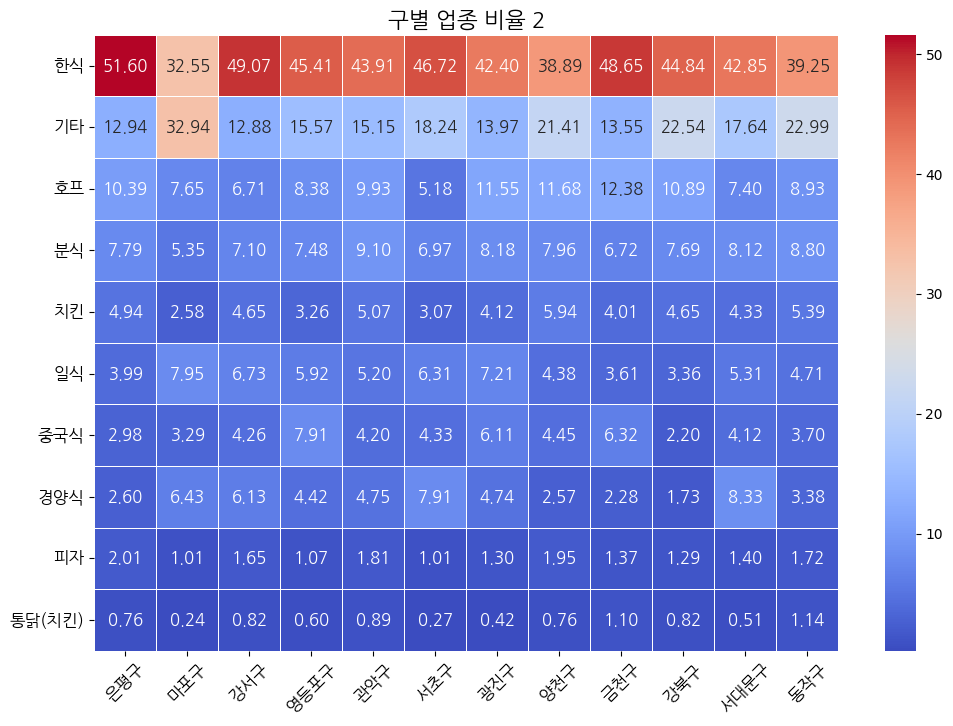

In [33]:

plt.figure(figsize=(12, 8))
ax = sns.heatmap(gu_ratio_df2, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# X축, Y축 한글 폰트 적용
plt.xticks(fontsize=14, rotation=45, fontproperties=fontprop)
plt.yticks(fontsize=14, rotation=0, fontproperties=fontprop)
plt.title("구별 업종 비율 2", fontproperties=fontprop, fontsize=16)

# Seaborn 내부 텍스트(annot)에도 한글 폰트 강제 적용
for text in ax.texts:
    text.set_fontproperties(fontprop)

plt.show()


1. 위의 두 히트맵을 보면 각 업종별로 구마다 비율이 4배가량 차이가 나는 등 분포 편차가 있는 것을 알 수 있다.
2. 여기서 업종별 비율과 폐업률을 연결시켜보자. 어떤 구에서 특정 업종의 비율이 지나치게 높으면 폐업률의 증가로 이어지는가? 그 반대도 성립하는가?
3. 서울시 전체, 구별 업종 비율은 수렴하는 경향이 있는가? 혹은 증가하거나 감소하는 추세가 있나?

비교적 여러 카테고리가 혼합된 한식과 기타는 제외하고 업종별 분석을 실시한다.

In [34]:
commercial_district = ['강남구', '종로구', '중구', '영등포구', '서초구']
mixed_district = ['마포구', '용산구', '성동구', '광진구', '송파구', '노원구', '은평구', '강동구', '관악구', '서대문구', '동작구']
residence_district = ['강서구', '구로구', '금천구', '양천구', '동대문구', '성북구', '강북구', '중랑구', '도봉구'] 
cleaned_df4['폐업 년도'] = cleaned_df4['폐업일자'].dt.year
cleaned_df4['폐업 년도'] = cleaned_df4['폐업 년도'].astype("Int64")
gu_list = cleaned_df4['구'].unique()
commercial_df = cleaned_df4[cleaned_df4['구'].isin(commercial_district)]
mixed_df = cleaned_df4[cleaned_df4['구'].isin(mixed_district)]
residence_df = cleaned_df4[cleaned_df4['구'].isin(residence_district)]


In [35]:
analysis_df = pd.DataFrame()

for i in range(2011, 2026):
    temp_df = cleaned_df4[(cleaned_df4['인허가일자'] < datetime(i,1,1)) & 
            ( (cleaned_df4['폐업일자'].isna()) | (cleaned_df4['폐업일자'] > datetime(i,1,1)) )]
    for gu, group in temp_df.groupby('구'):
        group_ratio = round(group['업태구분명'].value_counts(normalize = True) * 100, 2 )
        group_ratio = group_ratio.reset_index()
        group_ratio.columns = ['업종명', '업종 비율']
        group_ratio['분석 년도'] = i
        group_ratio['구'] = gu
        analysis_df = pd.concat([analysis_df, group_ratio], axis = 0, ignore_index = True)


commercial_df = analysis_df[analysis_df['구'].isin(commercial_district)]
mixed_df = analysis_df[analysis_df['구'].isin(mixed_district)]
residence_df = analysis_df[analysis_df['구'].isin(residence_district)]

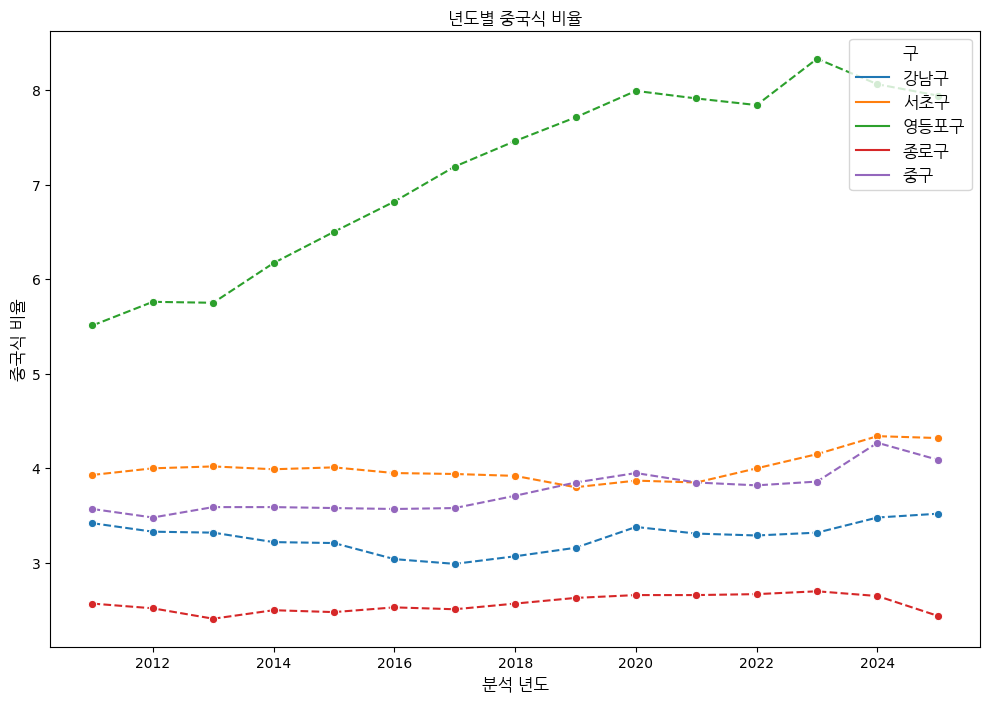

In [36]:
def show_trend(df, sort):
    
    plt.figure(figsize = (12, 8))
    
    temp_df = df[df['업종명'] == sort ]
    
    sns.lineplot(data = temp_df, x = '분석 년도', y = '업종 비율', 
                 hue = '구', marker = 'o', linestyle = '--' )
    plt.legend(title = '구', title_fontproperties = fontprop, prop = fontprop, loc = 'upper right')
    plt.xlabel('분석 년도', fontproperties = fontprop)
    plt.ylabel(f'{sort} 비율', fontproperties = fontprop)
    plt.title(f'년도별 {sort} 비율', fontproperties = fontprop)
    plt.show()

show_trend(commercial_df, '중국식')

1. 구별 치킨집 3년 폐업 비율은?
2. 구별 치킨집 년도별 폐업률은?

In [37]:
cleaned_df4

,인허가일자,영업상태코드,영업상태명,상세영업상태코드,상세영업상태명,폐업일자,지번주소,도로명주소,도로명우편번호,사업장명,최종수정일자,업태구분명,좌표정보(X),좌표정보(Y),인허가 연도,구,1년 폐업 여부,3년 폐업 여부,5년 폐업 여부,폐업 년도
0,2023-11-03,1,영업/정상,1,영업,NaT,서울특별시 중구 을지로6가 18-137,"서울특별시 중구 장충단로 249-10, 2층 (을지로6가)",4564.0,매취랑 동대문점,2023-11-03 17:09,한식,200614.4978,451667.7933,2023,중구,0,0,0,<NA>
1,2024-08-02,1,영업/정상,1,영업,NaT,서울특별시 노원구 공릉동 334-3,서울특별시 노원구 공릉로 127 (공릉동),1837.0,BLUE BOX(블루박스),2024-08-02 11:28,기타,206888.2788,457681.1294,2024,노원구,0,0,0,<NA>
2,2023-05-12,1,영업/정상,1,영업,NaT,서울특별시 송파구 가락동 84-6,"서울특별시 송파구 송이로20길 12-1, 1층 101호 (가락동)",5712.0,치카바,2023-05-12 14:40,일식,210536.3795,443748.6844,2023,송파구,0,0,0,<NA>
3,2023-03-31,1,영업/정상,1,영업,NaT,서울특별시 송파구 방이동 57 One57빌당,"서울특별시 송파구 올림픽로34길 27-23, One57빌딩 2층 201호 (방이동)",5547.0,오고보,2023-03-31 9:55,경양식,209835.4199,445884.5368,2023,송파구,0,0,0,<NA>
4,2023-03-31,1,영업/정상,1,영업,NaT,서울특별시 송파구 가락동 46-11 문종빌딩,"서울특별시 송파구 오금로36길 64, 문종빌딩 1층 (가락동)",5706.0,또봉이통닭 가락본동점,2023-03-31 11:17,치킨,210694.9140,444077.2546,2023,송파구,0,0,0,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515761,2001-09-15,3,폐업,2,폐업,2022-05-13,서울특별시 서대문구 창천동 2-19 (지상1층),"서울특별시 서대문구 연세로12길 28 (창천동,(지상1층))",3776.0,면가요시,2022-06-21 13:27,한식,194500.2851,450742.0375,2001,서대문구,0,0,0,2022
515762,2020-07-06,3,폐업,2,폐업,2022-05-14,서울특별시 강서구 마곡동 793-9 플레이스에이치(지상 1층) 107호,"서울특별시 강서구 강서로 395, 플레이스에이치 1층 107호 (마곡동)",7794.0,대식대 소룡포자,2022-05-14 15:34,중국식,185679.0000,450992.0000,2020,강서구,0,1,1,2022
515763,2001-07-16,1,영업/정상,1,영업,NaT,서울특별시 동대문구 이문동 316-2 지하1층,"서울특별시 동대문구 휘경로2길 19, 지하1층 (이문동)",2441.0,LA스시2me,2024-08-19 14:11,기타,205294.1706,454765.2611,2001,동대문구,0,0,0,<NA>
515764,1995-06-23,1,영업/정상,1,영업,NaT,서울특별시 종로구 명륜3가 1-14,서울특별시 종로구 명륜길 31 (명륜3가),3071.0,북경반점,2024-07-26 10:32,중국식,199506.1836,454029.3973,1995,종로구,0,0,0,<NA>


In [38]:
chicken_df = cleaned_df4[cleaned_df4['업태구분명'] == '치킨' ]


In [39]:
import re

chicken_group = chicken_df.groupby(by = ['구'] )
close_pct_3_df = pd.DataFrame()
for gu, group in chicken_group:
    for i in range(2010, 2022):
        year_group = group[group['인허가 연도'] == i]
        year_open_num = len(year_group)
        year_close_num = len(year_group[year_group['3년 폐업 여부'] == 1 ] )
        close_pct_3 =  round( (year_close_num / year_open_num ) * 100, 2)
        gu = re.sub(r'[(),\']','', str(gu))
        temp_df = pd.DataFrame({'구': [gu], '년도': [i], '3년 폐업률': [close_pct_3], '개업 매장 수' : [year_open_num]})
        close_pct_3_df = pd.concat( [close_pct_3_df, temp_df], axis = 0, ignore_index=True)



In [40]:
display(close_pct_3_df.groupby('구')['3년 폐업률'].mean().reset_index().sort_values(by = '3년 폐업률', ascending = True).head(5) )
display(close_pct_3_df.groupby('구')['3년 폐업률'].mean().reset_index().sort_values(by = '3년 폐업률', ascending = True).tail(5) )

,구,3년 폐업률
22,종로구,18.267500
11,동작구,19.457500
16,성북구,28.785833
20,용산구,28.815833
10,동대문구,29.626667


,구,3년 폐업률
8,노원구,36.817500
15,성동구,37.375000
4,관악구,38.052500
18,양천구,39.055833
1,강동구,43.180833


25개의 구는 폐업률이 최대 2배 정도 차이난다. 구 마다 차이가 크다는 것을 보여준다

In [41]:
mixed_district

['마포구', '용산구', '성동구', '광진구', '송파구', '노원구', '은평구', '강동구', '관악구', '서대문구', '동작구']

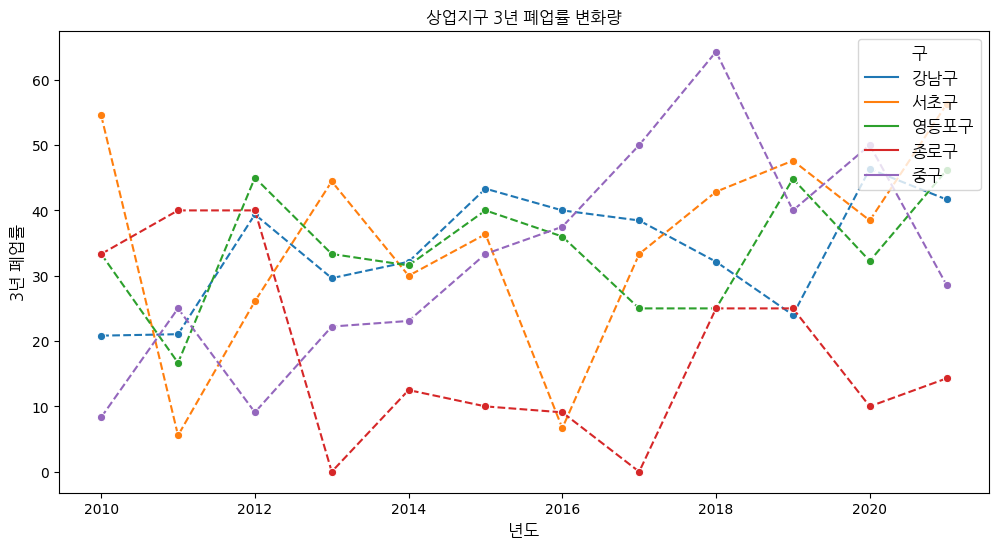

In [42]:
mixed_district_1 = mixed_district[:6]
mixed_district_2 = mixed_district[6:]
residence_district_1 = residence_district[:4]
residence_district_2 = residence_district[4:]
commercial_df = close_pct_3_df[close_pct_3_df['구'].isin(commercial_district)]
mixed_df1 = close_pct_3_df[close_pct_3_df['구'].isin(mixed_district_1)]
mixed_df2 = close_pct_3_df[close_pct_3_df['구'].isin(mixed_district_2)]
residence_df1 = close_pct_3_df[close_pct_3_df['구'].isin(residence_district_1)]
residence_df2 = close_pct_3_df[close_pct_3_df['구'].isin(residence_district_2)]


plt.figure(figsize =(12, 6))
sns.lineplot(x = '년도', y = '3년 폐업률', data = commercial_df, hue = '구', marker = 'o', linestyle = '--')

plt.xlabel('년도', fontproperties = fontprop)
plt.ylabel('3년 폐업률', fontproperties = fontprop)
plt.title('상업지구 3년 폐업률 변화량', fontproperties = fontprop)
plt.legend(title = '구', title_fontproperties = fontprop, prop = fontprop, loc ='upper right')

plt.show()


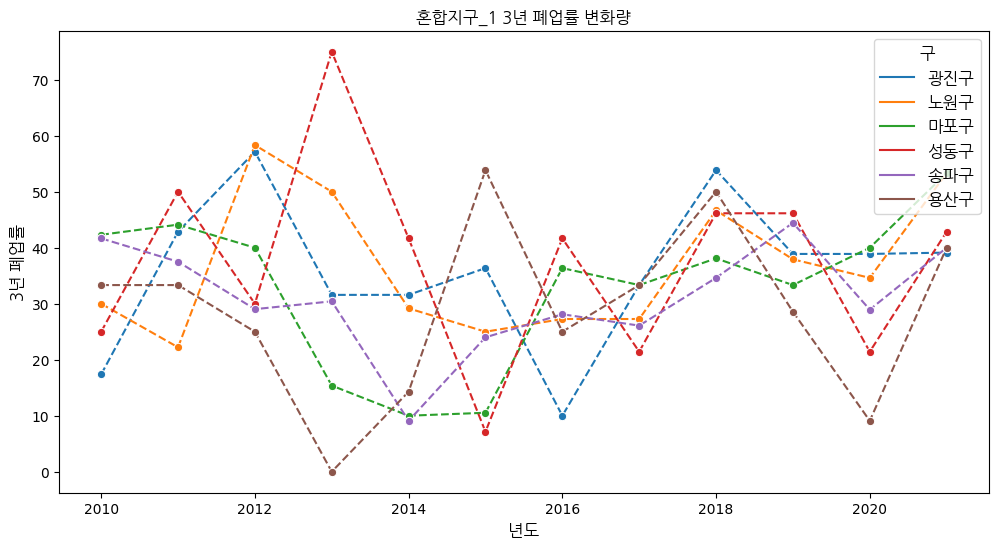

In [43]:

plt.figure(figsize =(12, 6))
sns.lineplot(x = '년도', y = '3년 폐업률', data = mixed_df1, hue = '구', marker = 'o', linestyle = '--')

plt.xlabel('년도', fontproperties = fontprop)
plt.ylabel('3년 폐업률', fontproperties = fontprop)
plt.title('혼합지구_1 3년 폐업률 변화량', fontproperties = fontprop)
plt.legend(title = '구', title_fontproperties = fontprop, prop = fontprop, loc ='upper right')

plt.show()


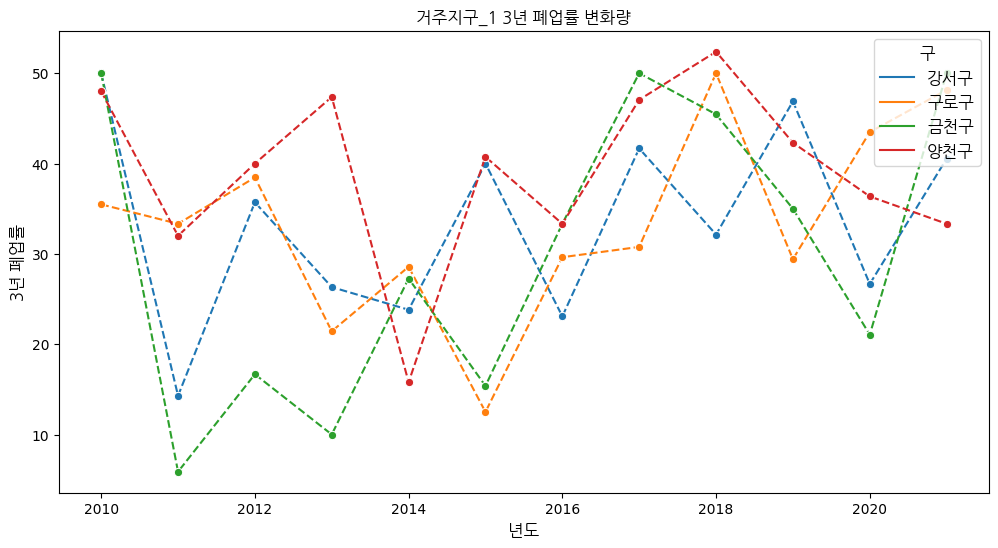

In [44]:

plt.figure(figsize =(12, 6))
sns.lineplot(x = '년도', y = '3년 폐업률', data = residence_df1, hue = '구', marker = 'o', linestyle = '--')

plt.xlabel('년도', fontproperties = fontprop)
plt.ylabel('3년 폐업률', fontproperties = fontprop)
plt.title('거주지구_1 3년 폐업률 변화량', fontproperties = fontprop)
plt.legend(title = '구', title_fontproperties = fontprop, prop = fontprop, loc ='upper right')

plt.show()

1. 종로구가 유일하게 3년 폐업률이 줄어드는 경향이 있으며 11년 평균 폐업률 역시 낮은 편. 제 1후보지
2. 동대문구는 평균 폐업률이 낮으면서 기울기 역시 0에 가까운 편으로 괜찮은 편. 제 2후보지
3. 금천구는 2021년에 폐업률이 급격하게 늘어낫었다. 다만, 해당 년도에 15개 매장 수만 개업을 했기에 적은 후보수로 인해 통계적 신뢰도 역시 고려해야한다.
4. 동작구는 3년 폐업률 평균이 가장 낮은 구로 제 3후보지 

이제 신규매장 대신 전체적인 구별 폐업률을 알아보자

In [45]:
chicken_df = cleaned_df4.copy()
chicken_df = chicken_df[chicken_df['업태구분명'] == '치킨']
chicken_brands = [
    'BBQ', 'BHC', '교촌', '네네', '굽네', '처갓집양념', '노랑통닭', '60계',
    '페리', '호식이두마리', '멕시카나', '지코바', '또래오래',  '푸라닭', 
    '가마로강정', '맘스터치', '땅땅', '오븐마루', '푸라닭', '가마치',
    '깐부', '후라이드참잘하는', '또봉이', '자담', '티바두마리',  '가마꿉', '기영이 숯불', '훌랄라치킨', 
    '꾸브라꼬', '뭔닭인지알지', '굽고굽고', '오븐에꾸운닭', '구어조은닭','돈치킨','본스치킨', '핫썬치킨'

]

chicken_after2010 = chicken_df[( chicken_df['인허가 연도'] >= 2015 ) & ( chicken_df['인허가 연도'] <= 2021 )]

top20_chicken_df = chicken_after2010[chicken_after2010['사업장명'].str.contains(
    '|'.join(chicken_brands) )]

def extract_brand(name):
    for brand in chicken_brands:
        if brand in name:
            return brand
    return '기타'

top20_chicken_df.loc[:, '브랜드'] = top20_chicken_df['사업장명'].apply(extract_brand)
top20_pct = top20_chicken_df.groupby('브랜드')['3년 폐업 여부'].mean()
top20_pct = round(top20_pct * 100 , 2).reset_index(name = '3년 폐업률')
top20_size = top20_chicken_df.groupby('브랜드').size().reset_index(name = '매장 수')

top20_pct = top20_pct.merge(top20_size, on = '브랜드', how = 'inner').sort_values(by = '3년 폐업률', ascending = True).reset_index(drop =True)
top20_pct.rename(columns = {'매장 수': '2015-2021 개업수'}, inplace= True)
top20_pct
#top20_pct.to_csv('2015-2021년 3년 폐업률.csv', encoding = 'utf-8-sig')

<ipython-input-45-3e49806924e5>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top20_chicken_df.loc[:, '브랜드'] = top20_chicken_df['사업장명'].apply(extract_brand)


,브랜드,3년 폐업률,2015-2021 개업수
0,기영이 숯불,0.00,10
1,후라이드참잘하는,0.00,18
2,60계,5.26,57
3,푸라닭,5.94,101
4,맘스터치,5.95,84
5,지코바,7.32,82
6,교촌,9.09,88
7,처갓집양념,10.34,58
8,굽네,12.28,57
9,페리,13.79,29


비비큐 270개 중 128개
교촌 68개 중 0개 투자금액 1억4천만. 투자금 대비 총 매출 45%, 관리충실도 63 월평균 매출액 6200만
처갓집 220개 중 129개. 투자금액 2600만. 투자금 대비 총 매출 69% 관리충실도 46 월평균 매출액 1850만
지코바 106개 중 8개. 투자금액 5700만. 투자금 대비 총 매출 44% 관리충실도 53 월평균 매출액 2500만
60계치킨 89개 중 6개. 투자금액 8555만. 투자금 대비 총 매출 41% 관리 충실도 60 월평균 매출액 3500만
노랑통닭 100개 중 11개. 투자금액  5330만. 투자금 대비 총 매출 65% 관리충실도 46 월 평균 매출액 3400만

충분한 자본, 치킨집 경영 경험 부족 -> 교촌 (카페형+배달)혹은 60계 (투자금 대비 총 매출은 조금 낮은 편이지만 )
적은 투자자본, 치킨집 경영 경험 충분 -> 처갓집 (배달형)
노랑통닭과 지코바는 신규 폐업률이 비슷한 편이고, 투자금액도 비슷한 편. 노랑통닭의 관리충실도가 조금 더 낮으나 (3년 폐업률도 3%가량 더 높다) 월 평균 매출액이 더 큰 편. 다만 지코바는 숯불구운통닭, 노랑통닭은 튀긴 치킨임을 감안하면 경쟁치킨업체 중 구운닭의 분포도를 살펴보는게 낫다. 
  

공정위 기준

60계는 여성, 처갓집은 남성.

배달형은 2000-5500만원 홀(카페)형은 6000-1억7천만. 

창업경영신문 기준 - 관리충실도

후보 동들은 성별, 세대, 연령별 인구 비율이 큰 차이가 없기에 고려하지 않는다.

1. 2010년 이후, 2022년 이전 개업한 상위 15개의 치킨브랜드 중 (5개 브랜드는 데이터에 포함되지 않는다), 3년 폐업률이 가장 낮은건 60계치킨이다.

2. 후보로 선정할 브랜드는 상위 5개 브랜드, 최대 3년 평균 폐업률이 8.89% 정도이다.

3. BBQ는 대한민국 3대 치킨 브랜드 치고는 3년 폐업률이 굉장히 높은 편. 

현재까지 

1. 구별 3년 폐업률 및 폐업률 기울기를 통해 구 후보지를 3개 선정하고
2. 치킨 브랜드 3년 폐업률을 통해 후보 브랜드 5개를 선정하였다. 

이제 마지막 분석 단계이다. 업체의 경쟁거리 내에 타 음식점 수 대비 같은 치킨 업종의 음식점이 상대적으로 많다면 3년 내 폐업률이 높아지는지, 만약 있다면 구별로 그러한 경향이 차이가 있는지 알아보자.

In [46]:
seoul_selected_districts = [
    '종로구', '용산구', '중구', '영등포구', '동작구', '중랑구',
    '강남구', '송파구', '양천구', '서초구', '노원구', '강서구'
]
final_df =  cleaned_df4.copy()
final_df =  final_df[(final_df['폐업일자'].isna()) | (final_df['폐업 년도'] >= 2020) ]
#final_df = final_df[final_df['구'].isin(seoul_selected_districts)]

# 1️⃣ 지번주소에서 "동" 또는 "가"를 추출하는 함수
def extract_dong_or_ga(address):
    if pd.isna(address):
        return None
    
    # "동" 추출
    match_dong = re.search(r'([가-힣]+[0-9]*동)', address)
    if match_dong:
        return match_dong.group(1)

    # "가" 추출 (구 다음에 나오는 "가")
    match_ga = re.search(r'구 ([가-힣]+[0-9]+가)', address)
    if match_ga:
        return match_ga.group(1)

    return None

# 2️⃣ 도로명주소에서 괄호 안의 "가" 값을 추출하는 함수
def extract_ga_from_brackets(address):
    if pd.isna(address):
        return None

    # 괄호 안에서 "가"가 포함된 값만 추출
    match = re.search(r'\(([^)]+[가|로|동])[^)]*\)', address)  # "가"가 있는 값만 추출
    return match.group(1) if match else None

final_df.loc[:, '동'] = final_df['지번주소'].apply(extract_dong_or_ga)

# ② 지번주소가 결측값이면, 도로명주소에서 괄호 안 "가" 추출
final_df.loc[:, '동'] = final_df.apply(
    lambda row: extract_ga_from_brackets(row['도로명주소']) if pd.isna(row['동']) else row['동'], axis=1
)

from pyproj import Transformer

transformer = Transformer.from_crs("epsg:2097", "epsg:4326", always_xy =True)
x_tm = final_df['좌표정보(X)'].to_numpy()
y_tm = final_df['좌표정보(Y)'].to_numpy()

lon, lat = transformer.transform(x_tm, y_tm)


final_df["경도"] = lon
final_df["위도"] = lat
final_df.dropna(subset = ['동'] , inplace = True)
final_df = final_df.drop(columns = ['좌표정보(X)', '좌표정보(Y)', '1년 폐업 여부', '영업상태코드', \
                                    '도로명우편번호', '최종수정일자', '영업상태명', '상세영업상태코드'])


final_df.reset_index(drop = True, inplace = True)

final_df.to_csv('10개 구 음식점.csv', encoding = 'utf-8-sig')

In [47]:
chicken_brands = [
    'BBQ', 'BHC', '교촌', '네네', '굽네', '처갓집양념', '노랑통닭', '60계', '부어치킨' , '멕시칸치킨','펀비어킹',
    '페리', '호식이두마리', '멕시카나', '지코바', '또래오래',  '푸라닭',  '또봉이', '멕시칸', '치킨플러스'
    '가마로강정', '맘스터치', '땅땅', '오븐마루', '푸라닭', '가마치', '자담', '가마치', '치킨마루', '훌랄라', '돈치킨'
    '깐부', '후라이드참잘하는', '또봉이', '자담', '티바두마리' ,   "코리엔탈 깻잎두마리치킨", "꾸브라꼬 숯불두마리치킨", "신통치킨", "후라이드참잘하는집",
    "순살만공격", "돈치킨", "누구나홀딱반한닭", "치킨신드롬", "깐부치킨", "치킨더홈",
    "치킨매니아", "투존치킨", "아라치 치킨", "호치킨", "보드람치킨", "동근이숯불두마리치킨",
    "알통떡강정", "치요남치킨", "본스치킨", "불로만치킨바베큐", "오븐마루", "맛닭꼬",
    "오븐에 꾸운 닭", "충만치킨", "디디치킨", "가마로강정", "코리안바베큐", "장모님치킨",
    "기영이 숯불 두마리치킨", "구도로통닭", "오태식해바라기치킨", "이춘봉인생치킨",
    "둘둘치킨", "동키치킨", "다사랑치킨", "닭가대표"
]

chicken_df = cleaned_df4[cleaned_df4['업태구분명'] == '치킨']
chicken_df = chicken_df[chicken_df['인허가 연도'] >= 2015]
brand_df =  chicken_df[chicken_df['사업장명'].str.contains('|'.join(chicken_brands) ) ]
non_brand_df =  chicken_df[~chicken_df['사업장명'].str.contains('|'.join(chicken_brands) ) ]
print(brand_df['3년 폐업 여부'].mean(), non_brand_df['3년 폐업 여부'].mean() )

0.1927891837756635 0.4227925184862984


In [48]:
temp_df = cleaned_df4[cleaned_df4['업태구분명'] == '치킨']
temp_df2 = temp_df[(temp_df['인허가 연도'] <= 2010) & (temp_df['인허가 연도'] >= 1990)]
temp_df3 = temp_df[(temp_df['인허가 연도'] >= 2010)]
print(temp_df2['3년 폐업 여부'].mean(),  temp_df3['3년 폐업 여부'].mean())

0.08482582168864397 0.3163850331925166


In [51]:
cleaned_df5 = cleaned_df4[ ( (cleaned_df4['폐업 년도'] >= 2010) |   (cleaned_df4['폐업 년도'].isna()) ) &
                (cleaned_df4['인허가 연도'] <= 2021) ].copy(deep = True)

from pyproj import Transformer

transformer = Transformer.from_crs("epsg:2097", "epsg:4326", always_xy =True)
x_tm = cleaned_df5['좌표정보(X)'].to_numpy()
y_tm = cleaned_df5['좌표정보(Y)'].to_numpy()

lon, lat = transformer.transform(x_tm, y_tm)


cleaned_df5["경도"] = lon
cleaned_df5["위도"] = lat


In [52]:
top_brands = ['교촌', '맘스터치', 'BBQ', '비비큐', 'BHC', '멕시카나', '굽네', '노랑통닭', 
 			'60계', '네네', '처갓집','호식이', '바른치킨','페리카나', '자담','지코바', 
		'순살만공격','후라이드참','누구나홀딱', '깐부치킨','가마치']
final_df =  cleaned_df5.copy()
roast_index = final_df[final_df['사업장명'].str.contains('|'.join(top_brands))].index
final_df.loc[roast_index, '업태구분명'] = '브랜드치킨'

seoul_selected_districts = [ '종로구','중구','영등포구','동작구', '용산구',
   '강남구', '송파구', '양천구', '서초구', '노원구'
]

final_df =  final_df[(final_df['폐업일자'].isna()) | (final_df['폐업 년도'] >= 2020) ]
final_df = final_df[final_df['구'].isin(seoul_selected_districts)]
final_df.drop(columns = ['상세영업상태코드', '도로명주소', '지번주소', '좌표정보(X)', '좌표정보(Y)', '최종수정일자', '도로명우편번호', '상세영업상태코드', '영업상태명', '영업상태코드']  ,inplace = True)
final_df.to_csv('상위 브랜드 10개 구 음식점.csv', encoding = 'utf-8-sig')

In [53]:
final_df =  cleaned_df5.copy()
roast_brand = [
    "굽네", "지코바", "돈치킨", "본스치킨", "핫썬치킨", "훌랄라", 
    "구어조은닭", "오꾸꼬", "굽고굽고", "오븐에꾸운닭", "맛닭꼬", "오븐마루", 
    "꾸브라꼬", "가마꿉", "뭔닭인지알지", "5학년"
]
roast_index = final_df[final_df['사업장명'].str.contains('|'.join(roast_brand))].index
final_df.loc[roast_index, '업태구분명'] = '오븐치킨'

seoul_selected_districts = [ '종로구','중구','영등포구','동작구', '용산구',
   '강남구', '송파구', '양천구', '서초구', '노원구'
]

final_df =  final_df[(final_df['폐업일자'].isna()) | (final_df['폐업 년도'] >= 2020) ]
final_df = final_df[final_df['구'].isin(seoul_selected_districts)]
final_df.drop(columns = ['상세영업상태코드', '도로명주소', '지번주소', '좌표정보(X)', '좌표정보(Y)', '최종수정일자', '도로명우편번호', '상세영업상태코드', '영업상태명', '영업상태코드']  ,inplace = True)
final_df.to_csv('10개 구 음식점.csv', encoding = 'utf-8-sig')

In [54]:
final_df.sample(30)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,인허가일자,상세영업상태명,폐업일자,사업장명,업태구분명,인허가 연도,구,1년 폐업 여부,3년 폐업 여부,5년 폐업 여부,폐업 년도,경도,위도
209405,1998-01-16,폐업,2022-12-26,장군주먹고기,한식,1998,영등포구,0,0,0,2022,126.891562,37.536827
94282,2017-04-19,폐업,2021-10-08,데바스테이트한남점,기타,2017,용산구,0,0,1,2021,127.006851,37.535262
286938,2020-12-10,폐업,2021-06-02,인생은 밥이다,한식,2020,강남구,1,1,1,2021,127.031887,37.510018
64192,2011-10-07,폐업,2021-06-15,블랙스테이크 대학로점,경양식,2011,종로구,0,0,0,2021,127.001082,37.580774
65476,1975-05-30,영업,NaT,명동부산집,한식,1975,중구,0,0,0,<NA>,126.981967,37.563137
334982,2021-03-09,폐업,2022-10-20,씨엔피푸드 가락점,한식,2021,송파구,0,1,1,2022,127.122796,37.496091
289998,2001-03-05,폐업,2022-02-07,쎄라비,경양식,2001,강남구,0,0,0,2022,127.017342,37.517267
267342,2021-12-08,영업,NaT,갓텐스시 센트럴시티점,일식,2021,서초구,0,0,0,<NA>,127.000731,37.504364
330308,2003-07-10,영업,NaT,(신)만다린,중국식,2003,송파구,0,0,0,<NA>,127.142062,37.492433
42468,1996-11-06,영업,NaT,오늘도 수고했어,경양식,1996,동작구,0,0,0,<NA>,126.978091,37.479824


In [55]:
conditions = [
    cleaned_df5['구'].isin(commercial_district),
    cleaned_df5['구'].isin(residence_district),
    cleaned_df5['구'].isin(mixed_district)
]

choices = ['상업지구', '거주지구', '혼합지구']

cleaned_df5['지구'] = np.select(conditions, choices, default = '해당없음')
district_df = cleaned_df5.drop(columns = ['최종수정일자', '도로명우편번호', '영업상태명', '영업상태코드'])
district_df.head(1)

,인허가일자,상세영업상태코드,상세영업상태명,폐업일자,지번주소,도로명주소,사업장명,업태구분명,좌표정보(X),좌표정보(Y),인허가 연도,구,1년 폐업 여부,3년 폐업 여부,5년 폐업 여부,폐업 년도,경도,위도,지구
25,2019-02-11,2,폐업,2023-09-05,서울특별시 종로구 숭인동 336 1층,"서울특별시 종로구 보문로7길 3-1, 1층 (숭인동)",홈푸드 스토리,한식,201946.7686,452809.3542,2019,종로구,0,0,1,2023,127.019936,37.577578,상업지구


In [58]:
ex_df_result = ex_df_result[ (ex_df_result['인허가 연도'] <= 2021) &  (ex_df_result['인허가 연도'] >= 2010) ]
temp_df = ex_df_result[ex_df_result['총 치킨점 수 - 폐업'] >= 10]
temp_df = temp_df[temp_df['업태구분명'] == '브랜드치킨']
print(temp_df['브랜드치킨 비율 - 폐업'].describe(), len(temp_df))
temp_df = ex_df_result[ex_df_result['총 치킨점 수 - 생존'] >= 10]
temp_df = temp_df[temp_df['업태구분명'] == '브랜드치킨']
print(temp_df['브랜드치킨 비율 - 생존'].describe(), len(temp_df))

count    179.000000
mean       0.290549
std        0.123499
min        0.000000
25%        0.216804
50%        0.270833
75%        0.342160
max        0.727273
Name: 브랜드치킨 비율 - 폐업, dtype: float64 179
count    947.000000
mean       0.270296
std        0.104077
min        0.000000
25%        0.200000
50%        0.260870
75%        0.333333
max        0.703704
Name: 브랜드치킨 비율 - 생존, dtype: float64 947


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


In [59]:
conditions = [
    cleaned_df4['구'].isin(commercial_district),
    cleaned_df4['구'].isin(residence_district),
    cleaned_df4['구'].isin(mixed_district)
]

choices = ['상업지구', '거주지구', '혼합지구']

cleaned_df4['지구'] = np.select(conditions, choices, default = '해당없음')
district_df = cleaned_df4.drop(columns = ['최종수정일자', '도로명우편번호', '영업상태명', '영업상태코드'])



chicken_df = district_df[district_df['업태구분명'] == '치킨']
from pyproj import Transformer

transformer = Transformer.from_crs("epsg:2097", "epsg:4326", always_xy =True)
x_tm = chicken_df['좌표정보(X)'].to_numpy()
y_tm = chicken_df['좌표정보(Y)'].to_numpy()

lon, lat = transformer.transform(x_tm, y_tm)


chicken_df["경도"] = lon
chicken_df["위도"] = lat

roast_brand = [
    "굽네", "지코바", "돈치킨", "본스치킨", "핫썬치킨", "훌랄라", 
    "구어조은닭", "오꾸꼬", "굽고굽고", "오븐에꾸운닭", "맛닭꼬", "오븐마루", 
    "꾸브라꼬", "가마꿉", "뭔닭인지알지", "5학년"
]
roast_index = chicken_df[chicken_df['사업장명'].str.contains('|'.join(roast_brand))].index
chicken_df.loc[roast_index, '업태구분명'] = '오븐치킨'
chicken_df = chicken_df[(chicken_df['폐업일자'].dt.year >= 2015) | (chicken_df['인허가 연도'] >= 2015 ) ]



from scipy.spatial import cKDTree
chicken_df = chicken_df.dropna(subset = ['경도'])
chicken_df = chicken_df.reset_index(drop = True)
# 반경 설정 (미터 단위)
district_radius = {
    '거주지구': 1500,  
    '혼합지구': 1000,  
    '상업지구': 700    
}


def get_radius_vectorized(district_series):
    return district_series.map(district_radius).fillna(np.nan).values


def compute_search_radius(df):
    lat_factor = df['지구 반경'].values / 111320
    return lat_factor

def compute_competition_vectorized(df):
    df_result = df.copy()
    df_target = df.copy()
     
    df_target['기존인덱스'] = df_target.index  # 원래 df의 인덱스 저장
    
    # KDTree 생성
    coords_pool = np.vstack((df_target['위도'], df_target['경도'])).T
    tree_pool = cKDTree(coords_pool)

    # 반경 계산
    df_target['지구 반경'] = get_radius_vectorized(df_target['지구'])
    df_target['검색 반경'] = compute_search_radius(df_target)

    # 탐색 반경 내 음식점 찾기
    query_points = np.vstack((df_target['위도'], df_target['경도'])).T
    search_radii = df_target['검색 반경'].values
    indices_list = tree_pool.query_ball_point(query_points, r=search_radii)

    # 결과 저장용 배열
    df_result['총 치킨점 수 - 3년'] = np.nan
    df_result['오븐치킨점 수 - 3년'] = np.nan        
    df_result["총 치킨점 수 - 폐업"] = np.nan
    df_result["오븐치킨점 수 - 폐업"] = np.nan
    
    total_counts = np.zeros(len(df_target), dtype=int)
    same_type_counts = np.zeros(len(df_target), dtype=int)
    total_counts_3year = np.zeros(len(df_target), dtype=int)
    same_type_counts_3year = np.zeros(len(df_target), dtype=int)

    
    for i, indices in enumerate(indices_list):
        # ✅ 기존 인덱스 사용하여 자기 자신 제외
        self_index = df_target['기존인덱스'].iloc[i]
        indices = [idx for idx in indices if idx != self_index]



        # ✅ 폐업한 가게에 대한 분석
        if (df_target.iloc[i]['3년 폐업 여부'] == 1) and (df_target.iloc[i]['인허가 연도'] <= 2021) and (df_target.iloc[i]['인허가 연도'] >= 2015):

            reference_date = df_target.iloc[i]['인허가일자'] + timedelta(days = 90)
            is_open = ((df.iloc[indices]['인허가일자'] + timedelta(days=90)) < reference_date) \
                & ((df.iloc[indices]['폐업일자'].isna()) | (df.iloc[indices]['폐업일자'] >= reference_date))
            valid_indices = np.array(indices)[is_open.to_numpy()]


            if len(valid_indices) >= 1:
                total_counts[i] = len(valid_indices)
                same_type_counts[i] = np.sum(df.iloc[valid_indices]['업태구분명'].values == '오븐치킨')

                # ✅ `.at[]`을 사용하여 명확한 행 업데이트
                df_result.at[self_index, "총 치킨점 수 - 폐업"] = total_counts[i]
                df_result.at[self_index, "오븐치킨점 수 - 폐업"] = same_type_counts[i]

        # ✅ 3년 생존 가게에 대한 분석
        if (df_target.iloc[i]['3년 폐업 여부'] == 0) and (df_target.iloc[i]['인허가 연도'] <= 2021) and (df_target.iloc[i]['인허가 연도'] >= 2015):

            reference_date_3year = df_target.iloc[i]['인허가일자'] + timedelta(days=90)
            is_open_3year = ((df.iloc[indices]['인허가일자'] + timedelta(days=90)) < reference_date_3year) \
                & ((df.iloc[indices]['폐업일자'].isna()) | (df.iloc[indices]['폐업일자'] >= reference_date_3year))
            valid_indices_3year = np.array(indices)[is_open_3year.to_numpy()]


            if len(valid_indices_3year) >= 1:
                total_counts_3year[i] = len(valid_indices_3year)
                same_type_counts_3year[i] = np.sum(df.iloc[valid_indices_3year]['업태구분명'].values == '오븐치킨')

                # ✅ `.at[]`을 사용하여 명확한 행 업데이트
                df_result.at[self_index, '총 치킨점 수 - 3년'] = total_counts_3year[i]
                df_result.at[self_index, "오븐치킨점 수 - 3년"] = same_type_counts_3year[i]

    # ✅ 0으로 나누는 문제 방지
    df_result['오븐치킨 비율 - 폐업'] = np.where(
        df_result["총 치킨점 수 - 폐업"] > 0,
        df_result["오븐치킨점 수 - 폐업"] / df_result["총 치킨점 수 - 폐업"],
        0
    )

    df_result['오븐치킨 비율 - 3년'] = np.where(
        df_result["총 치킨점 수 - 3년"] > 0,
        df_result["오븐치킨점 수 - 3년"] / df_result["총 치킨점 수 - 3년"],
        0
    )

    return df_result

# 경쟁 분석 실행
ex_df_result = compute_competition_vectorized(chicken_df)

<ipython-input-59-9efec5f710fc>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicken_df["경도"] = lon
<ipython-input-59-9efec5f710fc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicken_df["위도"] = lat
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  retu

In [60]:
ex_df_result = ex_df_result[ (ex_df_result['인허가 연도'] <= 2021) &  (ex_df_result['인허가 연도'] >= 2015) ]
temp_df = ex_df_result[ex_df_result['총 치킨점 수 - 폐업'] >=5]
temp_df = temp_df[temp_df['업태구분명'] == '오븐치킨']
print(temp_df['오븐치킨 비율 - 폐업'].describe(), len(temp_df))
temp_df = ex_df_result[ex_df_result['총 치킨점 수 - 3년'] >= 5]
temp_df = temp_df[temp_df['업태구분명'] == '오븐치킨']
print(temp_df['오븐치킨 비율 - 3년'].describe(), len(temp_df))

count    33.000000
mean      0.082078
std       0.063168
min       0.000000
25%       0.037037
50%       0.075000
75%       0.117647
max       0.285714
Name: 오븐치킨 비율 - 폐업, dtype: float64 33
count    164.000000
mean       0.054562
std        0.048649
min        0.000000
25%        0.000000
50%        0.047619
75%        0.086957
max        0.250000
Name: 오븐치킨 비율 - 3년, dtype: float64 164


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


In [71]:
after_2010 = cleaned_df5[(cleaned_df5['인허가 연도'] >= 2020) & (cleaned_df5['인허가 연도'] <= 2021) ]
grouped_df = after_2010.groupby('구')['3년 폐업 여부'].agg(['count', 'mean']).sort_values(by = 'mean').reset_index()
grouped_df.rename(columns = {'count' : '매장 수', 'mean' : '3년 폐업률'}, inplace = True)
#grouped_df.to_csv('2020-2021년 구별 3년 폐업률.csv', encoding = 'utf-8-sig')
seoul_selected_districts = [
    '종로구', '용산구', '중구', '영등포구', '동작구', '중랑구',
    '강남구', '송파구', '양천구', '서초구', '노원구'
]
temp_df = grouped_df[grouped_df['구'].isin(seoul_selected_districts)]
temp_df

,구,매장 수,3년 폐업률
0,종로구,677,0.217134
1,용산구,982,0.271894
2,중구,803,0.295143
3,영등포구,1330,0.345865
4,동작구,522,0.362069
5,중랑구,628,0.366242
9,노원구,773,0.390686
14,서초구,1120,0.420536
16,송파구,1756,0.425399
19,양천구,754,0.437666


In [73]:
display(grouped_df.head(5))
display(grouped_df.tail(5))

,구,매장 수,3년 폐업률
0,종로구,677,0.217134
1,용산구,982,0.271894
2,중구,803,0.295143
3,영등포구,1330,0.345865
4,동작구,522,0.362069


,구,매장 수,3년 폐업률
20,강남구,2926,0.438824
21,강서구,1623,0.452865
22,광진구,906,0.471302
23,강동구,954,0.489518
24,관악구,1279,0.498827


In [68]:
chicken_district_df = cleaned_df5[cleaned_df5['업태구분명'] == '치킨']
chicken_district_df =chicken_district_df[chicken_district_df['구'].isin(seoul_selected_districts)]
after_2010 = chicken_district_df[(chicken_district_df['인허가 연도'] >= 2020) & (chicken_district_df['인허가 연도'] <= 2021) ]
grouped_df = after_2010.groupby('구')['3년 폐업 여부'].agg(['count', 'mean']).sort_values(by = 'mean')

grouped_df.rename(columns = {'count' : '매장 수', 'mean' : '3년 폐업률'}, inplace = True)
#grouped_df.to_csv('2020-2021년 구별 치킨 3년 폐업률.csv', encoding = 'utf-8-sig')
grouped_df

,매장 수,3년 폐업률
구,,
종로구,17,0.117647
용산구,16,0.187500
동작구,29,0.241379
송파구,73,0.342466
양천구,49,0.346939
중구,11,0.363636
영등포구,57,0.385965
중랑구,46,0.391304
강남구,65,0.446154


In [69]:
display(grouped_df.head(5))
display(grouped_df.tail(5))

,매장 수,3년 폐업률
구,,
종로구,17,0.117647
용산구,16,0.187500
동작구,29,0.241379
송파구,73,0.342466
양천구,49,0.346939


,매장 수,3년 폐업률
구,,
영등포구,57,0.385965
중랑구,46,0.391304
강남구,65,0.446154
노원구,56,0.446429
서초구,42,0.452381


In [63]:

# 1️⃣ 지번주소에서 "동" 또는 "가"를 추출하는 함수
def extract_dong_or_ga(address):
    if pd.isna(address):
        return None
    
    # "동" 추출
    match_dong = re.search(r'([가-힣]+[0-9]*동)', address)
    if match_dong:
        return match_dong.group(1)

    # "가" 추출 (구 다음에 나오는 "가")
    match_ga = re.search(r'구 ([가-힣]+[0-9]+가)', address)
    if match_ga:
        return match_ga.group(1)

    return None

# 2️⃣ 도로명주소에서 괄호 안의 "가" 값을 추출하는 함수
def extract_ga_from_brackets(address):
    if pd.isna(address):
        return None

    # 괄호 안에서 "가"가 포함된 값만 추출
    match = re.search(r'\(([^)]+[가|로|동])[^)]*\)', address)  # "가"가 있는 값만 추출
    return match.group(1) if match else None

filtered_2010.loc[:, '동'] = filtered_2010['지번주소'].apply(extract_dong_or_ga)

# ② 지번주소가 결측값이면, 도로명주소에서 괄호 안 "가" 추출
filtered_2010.loc[:, '동'] = filtered_2010.apply(
    lambda row: extract_ga_from_brackets(row['도로명주소']) if pd.isna(row['동']) else row['동'], axis=1
)
filtered_2010.dropna(subset = ['동'] , inplace = True)


NameError: name 'filtered_2010' is not defined

In [ ]:
target_df = cleaned_df5.copy(deep = True)
target_df.loc[:, '동'] = target_df['지번주소'].apply(extract_dong_or_ga)

target_df.loc[:, '동'] = target_df.apply(
    lambda row: extract_ga_from_brackets(row['도로명주소']) if pd.isna(row['동']) else row['동'], axis=1
)
target_df.dropna(subset = ['동'] , inplace = True)


chicken_target_df = target_df.copy()
chicken_target_df = chicken_target_df[chicken_target_df['업태구분명'] == '치킨']
after_2010 = chicken_target_df[(chicken_target_df['인허가 연도'] >= 2010) & (chicken_target_df['인허가 연도'] <= 2021)]
grouped_2010 = after_2010.groupby(['구', '동'])['3년 폐업 여부'].agg(['count', 'mean'])
grouped_filtered_2010 = grouped_2010[grouped_2010['count'] >= 20 ] 



all_target_df = target_df.copy()
all_after_2010 = all_target_df[(all_target_df['인허가 연도'] >= 2010) & (all_target_df['인허가 연도'] <= 2021)]
all_grouped_2010 = all_after_2010.groupby(['구', '동'])['3년 폐업 여부'].agg(['count', 'mean'])
all_grouped_filtered_2010 = all_grouped_2010[all_grouped_2010['count'] >= 300 ] 

grouped_filtered_2010 = grouped_filtered_2010.rename(
    columns={'count': '치킨집 수', 'mean': '치킨집 3년 폐업률'}
)

all_grouped_filtered_2010 = all_grouped_filtered_2010.rename(
    columns={'count': '전체 매장 수', 'mean': '전체 3년 폐업률'}
)

final_df =grouped_filtered_2010.merge(all_grouped_filtered_2010, on = ['구', '동'], how = 'inner' )



In [ ]:

chicken_target_df = target_df.copy()
chicken_target_df = chicken_target_df[chicken_target_df['업태구분명'] == '치킨']
after_2010 = chicken_target_df[(chicken_target_df['인허가 연도'] >= 2010) & (chicken_target_df['인허가 연도'] <= 2019)]
grouped_2010 = after_2010.groupby(['구', '동'])['5년 폐업 여부'].agg(['count', 'mean'])




all_target_df = target_df.copy()
all_after_2010 = all_target_df[(all_target_df['인허가 연도'] >= 2010) & (all_target_df['인허가 연도'] <= 2019)]
all_grouped_2010 = all_after_2010.groupby(['구', '동'])['5년 폐업 여부'].agg(['count', 'mean'])

grouped_filtered_2010 = grouped_2010.rename(
    columns={'count': '5년 치킨집 수', 'mean': '치킨집 5년 폐업률'}
)

all_grouped_filtered_2010 = all_grouped_2010.rename(
    columns={'count': '5년 전체 매장 수', 'mean': '전체 5년 폐업률'}
)

final_df =grouped_filtered_2010.merge(all_grouped_filtered_2010, on = ['구', '동'], how = 'inner' )

In [ ]:
df1 = pd.read_csv('/kaggle/working/2015-2019년 5년 폐업률.csv', encoding = 'utf-8-sig', index_col = 0)
df2 = pd.read_csv('/kaggle/working/2015-2021년 3년 폐업률.csv', encoding = 'utf-8-sig', index_col = 0)
df1.rename(columns = {'매장 수': '5년 매장 수'}, inplace= True)
df2.rename(columns = {'매장 수': '3년 매장 수'}, inplace= True)
new_df = df2.merge(df1, on = '브랜드', how = 'inner')
new_df


최종후보지


1. 지코바 

혜화동 - 성균관대, 카톨릭대학교. 20대의 음식점 매출 비중 높음. 저녘 시간대에 매출 비중 커짐. 식당 다수. 구운치킨 음식점이 근처에 없기에 공략가능? 지코바? 여성 비율이 55% 매출. 음식점 집중적으로 모여있는 곳에 교촌치킨, 맘스터치 정도. 아니면 노랑통닭, 림스치킨 (튀긴 치킨) 정도가 있음 -> 대학생들 매장홀로 지코바처럼 구운 치킨으로? 1후보지


2. 60계 치킨

서초구의 방배3동, 방배1동은 10대 인구가 4만명 가량임. 그렇다보니 어머니, 아이들을 타겟으로 한 60계 치킨이 방배동에서 2019년부터 영업중. 신논현역 역시 잠원동, 반포동 등에 10대 인구 다수 분포, 2016년부터 60계치킨 영업중. 즉, 10대 인구가 많고 학부모가 많은 곳-> 서초구는 포화상태이므로 다른 구를 알아보자. 양천구의 경우 신정동, 신월동에 걸쳐 3군데 60계 치킨 있음. 2014/2020/2019년부터 운영중. 강남구 - 서초구 - 양천구 강남 3구에서 잠실2동, 잠실7동, 잠실본동, 삼전동, 잠실3동 서부부근엔 1.5km기준 60계 치킨매장이 겹치지 않음. 왼쪽으로는 삼성동에도 없음. 

이 부분을 제외하고 다른 곳은 조금씩 겹침. 그렇다면 이곳에 문제가 있어서 입점을 안하나? -> 1.5km 반경 내의 해당 동을엔 10대 거주인구가 약 9만명 가량 있음. 또한 이 부근에 치킨집도 15군데 가량 존재 -> 치킨 수요 충분. 또한 옆의 삼성동 동부지역까지도 커버 가능. 잠실본동의 경우 임대료가 3.3m^2 당 18만원 가량으로 서울평균, 자치구 평균인 15만원에 비해 3만원 가량 높음. 잠실 7동의 경우 12만으로 평균보다 낮은 편. 다만, 잠실7동은 삼전동 (10대 거주인구 3만)까지 커버하기 힘듦. 석촌동이 삼전동 오른쪽인데 여기도 3만. 잠실본동에 임대료가 좀 있더라도 여기에 해서 확실히 커버하는게 나음. 임대료가 낮은 이유가 있음 (22만에서 12만까지 2년만에 내려감. 특히 이쪽엔 잠실야구장 등이 많은 지역을 차지하고 있어서 야구장에 있는 치킨집에서 대부분의 사람들이 살것). 삼성1동 (강남구) 역시 청담동, 삼성1동, 삼성2동 + 대치2,4동 북부지역까지 약 6-7만명 있으나 임대료가 최근 2년간 11만에서 22만으로 가파르게 오름. 계속 오를 가능성이 있는 한, 잠실본동이 적당함. 또한 근처에 같은 건강치킨브랜드인 바른치킨 존재하지 않음.

3. 처갓집양념, 푸라닭 - 마찬가지로 처갓집양념은 페리카나, 멕시카나 등 핵심 양념치킨 경쟁브랜ㄷ, 푸라닭은 프리미엄 경쟁브랜드의 위치 및 동일브랜드의 위치를 피해서, 20-30대 인구가 많은 자치구 중 치킨집 수요가 많은 곳으로

### 최종 정리본



1. 1990-2010년 전, 후로 3년 폐업률이 8% 가량에서 31% 정도로 4배 가량 늘어남. 포화상태에 가까워졌으며 이는 경쟁력있는 브랜드 혹은 틈새시장을 공략해야함을 의미.
2. 매장 수 기준 상위 30개 브랜드 vs 비프렌차이즈 혹은 소규모 브랜드 폐업률을 비교 시, 2015년 이후 19% vs 42% 가량으로 2배 차이. 상위 브랜드를 선택해야함을 보여줌
3. 3년 폐업률 기준 2015년 이후로 교촌, 지코바, 푸라닭, 처갓집, 60계 정도가 적은 편. 이는 BBQ나 BHC 등 대형 프랜차이즈보다 훨씬 낮은 수치.
4. 초기창업비용, 관리지수, 3년 폐업률, 틈새시장공략 가능성 등을 보았을 때 60계, 지코바 위주로 먼저 분석. 그리고 같은 방법으로 푸라닭, 교촌, 처갓집도 가능함을 보여줌. 3곳 모두 20-30대 인구가 많은 곳 중, 교촌은 비프렌차이즈, 처갓집양념은 멕시카나, 페리카나 등 양념치킨 강세 브랜드 가 없는 곳, 푸라닭은 프리미엄 브랜드가 없는 곳. (다만 매출데이터가 없는 이상 한계도 있음을 언급. 가맹점문의하여 프렌차이즈에서 확보한 데이터를 가지고 상담하는게 중요)
5. 60계는 서초구, 노원구, 강남구, 양천구 등 10대 상주인구 많은 곳. 이 중, 바른치킨 또는 동일 브랜드 (건강치킨 브랜드)가 없는 곳 (1.5km 배달반경으로 잡고) 중 임대료가 적은 곳, 그 외에 특징들 보기
6. 지코바는 오븐치킨/전체치킨 매장 수 중 비율이 적은 곳. 혜화동의 성균관대-카톨릭대학교-방송통신대학교 대학가로. 오른쪽 대학가의 높은 폐업비율과 비교하며 왼쪽으로. 또한 혜화동은 종로구로, 3년 폐업 비율이 가장 적은 것도 언급. (3년 폐업 비율 적은 상위 3구). 무엇보다 오븐치킨 중 3년 폐업한 경우와 생존한 경우 오븐치킨/전체치킨의 비율은 약 60%차이가 남 (7.5% vs 4.7%) 
7. 처갓집이나 푸라닭은 간결한 설명으로 비슷한 방법으로 할 수 있다! 정도로만 언급하고 교촌까지만 하자. 교촌은 매장홀 + 20-40대 유동인구 많은 곳 + 도심지 구 중 폐업률 낮은 종로구, 중구 등 + 임대료 적절히 + 근처에 치킨집은 많으나 비프랜차이즈, 소규모 브랜드인 경우를 고르자+ 창업비용이 많을때로.